# A Comprehensive Exploration of Covid-19 in Malaysia 🇲🇾
<i>Sidharrth Nagappan, Eugene Kan, Tan Zhi Hang, 2021</i>
<br>
<br>
<img src="covid-malaysia.jpeg" width="400px"/>
<br>
<br>

This notebook will conduct a comprehensive analysis of Covid-19 in Malaysia, while evaluating the performance of the nation in combatting the pandemic and putting this performance up against other countries in South East Asia. Covid-19 has taken the world by storm and we use open data to extract critical insights.

There are 3 parts to this notebook:

* Preprocessing
* Exploratory Data Analysis
* Modelling

#### Importing the necessary libraries
Additional libraries:
* Tensorflow
* Boruta

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression, RFE, VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split  
from sklearn.tree import DecisionTreeRegressor  
from sklearn.metrics import mean_squared_error,mean_absolute_error
warnings.filterwarnings('ignore')

#### Reading dataset files

Should you want to change the datasets or update to the latest date, place in folders from https://github.com/CITF-Malaysia/citf-public:
* cases
  * epidemic
* vaccination
  * vaccination
  
The following datasets will be used, all sourced from the Ministry of Health's Open Data:
1. cases_malaysia.csv
2. cases_state.csv
3. clusters.csv
4. deaths_malaysia.csv
5. deaths_state.csv
6. hospital.csv
7. icu.csv
8. pkrc.csv
9. tests_malaysia.csv
10. tests_state.csv

In [2]:
cases_malaysia = pd.read_csv('./cases/epidemic/cases_malaysia.csv')
cases_state = pd.read_csv('./cases/epidemic/cases_state.csv')
clusters = pd.read_csv('./cases/epidemic/clusters.csv')
deaths_malaysia = pd.read_csv('./cases/epidemic/deaths_malaysia.csv')
deaths_state = pd.read_csv('./cases/epidemic/deaths_state.csv')
hospital = pd.read_csv('./cases/epidemic/hospital.csv')
icu = pd.read_csv('./cases/epidemic/icu.csv')
pkrc = pd.read_csv('./cases/epidemic/pkrc.csv')
tests_malaysia = pd.read_csv('./cases/epidemic/tests_malaysia.csv')
tests_state = pd.read_csv('./cases/epidemic/tests_state.csv') 
vax_malaysia = pd.read_csv('./vaccination/vaccination/vax_malaysia.csv') 
vax_state = pd.read_csv('./vaccination/vaccination/vax_state.csv') 
vaxreg_malaysia = pd.read_csv('./vaccination/registration/vaxreg_malaysia.csv') 
vaxreg_state = pd.read_csv('./vaccination/registration/vaxreg_state.csv') 
population = pd.read_csv('./vaccination/static/population.csv')
checkins = pd.read_csv('./cases/mysejahtera/checkin_malaysia.csv')
income = pd.read_csv('./vaccination/static/income.csv')
aefi = pd.read_csv('./cases/vaccination/aefi.csv')
trace_malaysia = pd.read_csv('./cases/mysejahtera/trace_malaysia.csv')

In [88]:
vax_state = pd.read_csv('./vaccination/vaccination/vax_state.csv') 
population = pd.read_csv('./cases/static/population.csv')
trace_malaysia = pd.read_csv('./cases/mysejahtera/trace_malaysia.csv')
population.head()

,state,idxs,pop,pop_18,pop_60,pop_12
0,Malaysia,0,32657400,23409600,3502000,3147500
1,Johor,1,3781000,2711900,428700,359900
2,Kedah,2,2185100,1540600,272500,211400
3,Kelantan,3,1906700,1236200,194100,210600
4,Melaka,4,932700,677400,118500,86500


## Pre-processing
#### You can collapse this section, as there are many cells

1. Restructure dataset format by melting/pivot table
2. Deal with missing values and outliers (missing values will be dropped and outliers will be checked on case-by-case basis)

#### Conditional Handling of Outliers
Outliers are handled on a case-by-case basis because many outliers are usually meaningful, especially in the case of Covid statistics. 

#### Handling of missing values
Covid statistics are critical and replacing by the average or median of the statistic can be drastic. Since most missing values are attributed to the data not existing at that point in time (e.g. testing only started in Malaysia in January 2021)

In [4]:
before_pp_cases_malaysia = cases_malaysia.copy()
before_pp_cases_state = cases_state.copy()
before_pp_clusters = clusters.copy()
before_pp_deaths_malaysia = deaths_malaysia.copy()
before_pp_deaths_state = deaths_state.copy()
before_pp_hospital = hospital.copy()
before_pp_icu = icu.copy()
before_pp_pkrc = pkrc.copy()
before_pp_tests_malaysia = tests_malaysia.copy()
before_pp_tests_state = tests_state.copy()
before_pp_vax_malaysia = vax_malaysia.copy()
before_pp_vax_state = vax_state.copy()
before_pp_vaxreg_malaysia = vaxreg_malaysia.copy()
before_pp_vaxreg_state = vaxreg_state.copy()
before_pp_population = population.copy()
before_pp_checkins = checkins.copy()
before_pp_income = income.copy()

### Cases Malaysia

In [5]:
# cases_malaysia

In [6]:
cases_malaysia.isna().sum()

date                         0
cases_new                    0
cases_import                 0
cases_recovered              0
cases_active                 0
cases_cluster                1
cases_pvax                   1
cases_fvax                   1
cases_child                  1
cases_adolescent             1
cases_adult                  1
cases_elderly                1
cluster_import             342
cluster_religious          342
cluster_community          342
cluster_highRisk           342
cluster_education          342
cluster_detentionCentre    342
cluster_workplace          342
dtype: int64

In [7]:
cases_malaysia.drop_duplicates(inplace=True)

In [8]:
# cluster columns are irrelevant, remove them
cases_malaysia.drop(columns=['cluster_import', 'cluster_religious', 'cluster_community', 'cluster_highRisk', 'cluster_education', 'cluster_detentionCentre', 'cluster_workplace'], inplace=True)
# other dates with a null value, just drop that row
cases_malaysia.fillna(0, inplace=True)
# cases_malaysia.head()

### Cases State

In [9]:
# cases_state

In [10]:
cases_state.isna().sum()

date                 0
state                0
cases_new            0
cases_import         0
cases_recovered      0
cases_active         0
cases_cluster       16
cases_pvax          16
cases_fvax          16
cases_child         16
cases_adolescent    16
cases_adult         16
cases_elderly       16
dtype: int64

In [11]:
cases_state.drop_duplicates(inplace=True)

In [12]:
cases_state.fillna(0, inplace=True)

In [13]:
cases_state_pivoted = cases_state.pivot(index='date', columns='state', values='cases_new')
cases_state_pivoted.head()

state,Johor,Kedah,Kelantan,Melaka,Negeri Sembilan,Pahang,Perak,Perlis,Pulau Pinang,Sabah,Sarawak,Selangor,Terengganu,W.P. Kuala Lumpur,W.P. Labuan,W.P. Putrajaya
date,,,,,,,,,,,,,,,,
2020-01-25,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-29,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Clusters

In [14]:
# clusters

In [15]:
clusters.isna().sum()

cluster            0
state              0
district           0
date_announced     0
date_last_onset    0
category           0
status             0
cases_new          0
cases_total        0
cases_active       0
tests              0
icu                0
deaths             0
recovered          0
dtype: int64

In [16]:
clusters.drop_duplicates(inplace=True)

### Deaths Malaysia

In [17]:
# deaths_malaysia

In [18]:
 deaths_malaysia.isna().sum()

date              0
deaths_new        0
deaths_bid        0
deaths_new_dod    0
deaths_bid_dod    0
deaths_pvax       0
deaths_fvax       0
deaths_tat        0
dtype: int64

In [19]:
deaths_malaysia.drop_duplicates(inplace=True)

In [20]:
deaths_malaysia.drop(columns=['deaths_bid', 'deaths_new_dod', 'deaths_bid_dod', 'deaths_pvax', 'deaths_fvax', 'deaths_tat'], inplace=True)
# deaths_malaysia.head()

### Deaths State

In [21]:
# deaths_state

In [22]:
deaths_state.isna().sum()

date              0
state             0
deaths_new        0
deaths_bid        0
deaths_new_dod    0
deaths_bid_dod    0
deaths_pvax       0
deaths_fvax       0
deaths_tat        0
dtype: int64

In [23]:
deaths_state.drop_duplicates(inplace=True)

In [24]:
deaths_state_pivoted = deaths_state.pivot(index='date', columns='state', values='deaths_new')
deaths_state_pivoted.head()

state,Johor,Kedah,Kelantan,Melaka,Negeri Sembilan,Pahang,Perak,Perlis,Pulau Pinang,Sabah,Sarawak,Selangor,Terengganu,W.P. Kuala Lumpur,W.P. Labuan,W.P. Putrajaya
date,,,,,,,,,,,,,,,,
2020-03-17,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2020-03-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-20,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2020-03-21,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0


### Hospital

In [25]:
# hospital

In [26]:
hospital.isna().sum()

date                0
state               0
beds                0
beds_covid          0
beds_noncrit        0
admitted_pui        0
admitted_covid      0
admitted_total      0
discharged_pui      0
discharged_covid    0
discharged_total    0
hosp_covid          0
hosp_pui            0
hosp_noncovid       0
dtype: int64

In [27]:
hospital.drop_duplicates(inplace=True)

In [28]:
hospital.drop(columns=['beds', 'beds_noncrit', 'admitted_pui', 'admitted_total', 'discharged_pui', 'discharged_total','hosp_pui','hosp_noncovid'], inplace=True)
# hospital.head()

### ICU

In [29]:
# icu

In [30]:
icu.isna().sum()

date              0
state             0
beds_icu          0
beds_icu_rep      0
beds_icu_total    0
beds_icu_covid    0
vent              0
vent_port         0
icu_covid         0
icu_pui           0
icu_noncovid      0
vent_covid        0
vent_pui          0
vent_noncovid     0
vent_used         0
vent_port_used    0
dtype: int64

In [31]:
icu.drop_duplicates(inplace=True)

In [32]:
icu.drop(columns=['beds_icu', 'beds_icu_rep', 'beds_icu_total', 'vent', 'vent_port', 'icu_pui','icu_noncovid','vent_pui','vent_noncovid','vent_used','vent_port_used'], inplace=True)
# icu.head()

### PKRC

In [33]:
# pkrc

In [34]:
pkrc.isna().sum()

date               0
state              0
beds               0
admitted_pui       0
admitted_covid     0
admitted_total     0
discharge_pui      0
discharge_covid    0
discharge_total    0
pkrc_covid         0
pkrc_pui           0
pkrc_noncovid      0
dtype: int64

In [35]:
pkrc.drop_duplicates(inplace=True)

In [36]:
pkrc.drop(columns=['beds', 'admitted_pui', 'admitted_total', 'discharge_pui', 'discharge_total', 'pkrc_pui','pkrc_noncovid'], inplace=True)
# pkrc.head()

### Test Malaysia

In [37]:
# tests_malaysia

In [38]:
tests_malaysia.isna().sum()

date      0
rtk-ag    0
pcr       0
dtype: int64

In [39]:
tests_malaysia.drop_duplicates(inplace=True)

In [40]:
tests_malaysia['total_testing'] = tests_malaysia['rtk-ag'] + tests_malaysia['pcr']
# tests_malaysia 

In [41]:
tests_malaysia.drop(columns=['rtk-ag', 'pcr'], inplace=True)
# tests_malaysia.head()

### Tests State

In [42]:
# tests_state

In [43]:
tests_state.isna().sum()

date      0
state     0
rtk-ag    0
pcr       0
dtype: int64

In [44]:
tests_state.drop_duplicates(inplace=True)

In [45]:
tests_state['total_testing'] = tests_state['rtk-ag'] + tests_state['pcr']
# tests_state

In [46]:
tests_state.drop(columns=['rtk-ag', 'pcr'], inplace=True)
# tests_state.head()

### Vaccination Malaysia

In [47]:
# vax_malaysia

In [48]:
vax_malaysia.isna().sum()

date                   0
daily_partial          0
daily_full             0
daily                  0
daily_partial_child    0
daily_full_child       0
cumul_partial          0
cumul_full             0
cumul                  0
cumul_partial_child    0
cumul_full_child       0
pfizer1                0
pfizer2                0
sinovac1               0
sinovac2               0
astra1                 0
astra2                 0
cansino                0
pending                0
dtype: int64

In [49]:
vax_malaysia.drop_duplicates(inplace=True)
vax_malaysia_all_attributes = vax_malaysia.copy()

In [50]:
# total up first and second dose
vax_malaysia_all_attributes['pfizer'] = vax_malaysia_all_attributes['pfizer1'] + vax_malaysia_all_attributes['pfizer2']
vax_malaysia_all_attributes['astra'] = vax_malaysia_all_attributes['astra1'] + vax_malaysia_all_attributes['astra2']
vax_malaysia_all_attributes['sinovac'] = vax_malaysia_all_attributes['sinovac1'] + vax_malaysia_all_attributes['sinovac2']

In [51]:
vax_malaysia.drop(columns=['daily_partial_child','cumul_partial','cumul_full','cumul','cumul_partial_child','cumul_full_child','pfizer1','pfizer2','sinovac1','sinovac2','astra1','astra2','cansino','pending'], inplace=True)
vax_malaysia['cumul'] = vax_malaysia['daily_full'].cumsum()
vax_malaysia.head()

,date,daily_partial,daily_full,daily,daily_full_child,cumul
0,2021-02-24,60,0,60,0,0
1,2021-02-25,1146,0,1146,0,0
2,2021-02-26,4115,1,4116,0,1
3,2021-02-27,6723,1,6724,0,2
4,2021-02-28,6699,3,6702,0,5


### Vaccination State

In [52]:
# vax_state

In [53]:
vax_state.isna().sum()

date                   0
state                  0
daily_partial          0
daily_full             0
daily                  0
daily_partial_child    0
daily_full_child       0
cumul_partial          0
cumul_full             0
cumul                  0
cumul_partial_child    0
cumul_full_child       0
pfizer1                0
pfizer2                0
sinovac1               0
sinovac2               0
astra1                 0
astra2                 0
cansino                0
pending                0
dtype: int64

In [54]:
vax_state.drop_duplicates(inplace=True)

In [55]:
# vax_state.drop(columns=['daily_partial_child', 'daily_full_child','cumul_partial','cumul_full','cumul','cumul_partial_child','cumul_full_child','pfizer1','pfizer2','sinovac1','sinovac2','astra1','astra2','cansino','pending'], inplace=True)
# vax_state.head()

### Vaccination Registration Malaysia

In [56]:
# vaxreg_malaysia

In [57]:
vaxreg_malaysia.isna().sum()

date        0
state       0
total       0
phase2      0
mysj        0
call        0
web         0
children    0
elderly     0
comorb      0
oku         0
dtype: int64

In [58]:
vaxreg_malaysia.drop_duplicates(inplace=True)

In [59]:
vaxreg_malaysia.drop(columns=['phase2', 'mysj','call','web','children','elderly','comorb','oku'], inplace=True)
# vaxreg_malaysia.head()

### Vaccination Registration State

In [60]:
# vaxreg_state

In [61]:
vaxreg_state.isna().sum()

date        0
state       0
total       0
phase2      0
mysj        0
call        0
web         0
children    0
elderly     0
comorb      0
oku         0
dtype: int64

In [62]:
vaxreg_state.drop_duplicates(inplace=True)

In [63]:
vaxreg_state.drop(columns=['phase2', 'mysj','call','web','children','elderly','comorb','oku'], inplace=True)
# vaxreg_state.head()

### Population

In [64]:
# population

In [65]:
# population.drop(columns=['pop_18', 'pop_60'], inplace=True)
# population.head()

### Income

In [66]:
income = income[income['Year'] == 2020]
income.rename(columns={'Country/State': 'state', 'Mean Monthly Household Gross Income': 'income', 'Year': 'year'}, inplace=True)
# income.head()

### Check-Ins

In [67]:
checkins.isna().sum()

date          0
checkins      0
unique_ind    0
unique_loc    0
dtype: int64

### Traces

In [92]:
trace_malaysia.fillna(0,inplace=True)
trace_malaysia.drop_duplicates(inplace=True)

## Exploratory Data Analysis

Exploratory Data Analysis helps us obtain a statistical overview of the data and answer interesting questions to extract patterns that may exist.

### Is there a correlation between the mean income of a state and the number of cases? (taking population as the third variable)

We wonder whether there is a possibility that higher-income and more densely populated states are more susecptible to Covid-19 than smaller states. First, we phrased it as a two-factor problem, but soon realised that **population is the confounding variable**.

In [68]:
# merge supplementary income dataset with the cases dataset on state
cases_income = pd.DataFrame(cases_state.groupby('state')['cases_new'].sum()).reset_index()
cases_income = cases_income.merge(income, on='state')
cases_income = cases_income.merge(population, on='state')
cases_income['income'] = cases_income['income'].astype(int)

In [69]:
# do a pearson correlation
cases_income[['cases_new', 'income', 'pop']].corr(method='pearson')

,cases_new,income,pop
cases_new,1.000000,0.248051,0.931784
income,0.248051,1.000000,0.068793
pop,0.931784,0.068793,1.000000


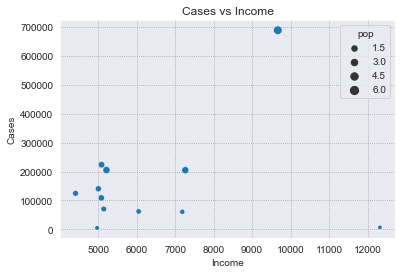

In [71]:
# plot relationship between cases_new and income
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(x='income', y='cases_new', size='pop', data=cases_income)
plt.xlabel('Income')
plt.ylabel('Cases')
plt.title('Cases vs Income')
plt.show()

There appears to be a weak correlation, hinting that Covid cases may not be a totally socio-economic one. As the average income of the state increases, the more populated it generally is, which would mean more cases. The population is a strong **confounding variable**.


### Is there a correlation between vaccination and daily cases at a national level?

We first obtain a new dataframe which only contains the date and the cummulative vaccination head count then we examine their correlation and visualize it using heatmap.

In [104]:
corr_vaccine = vax_malaysia[['date','cumul']]
malaysia_cases = cases_state[['date','state','cases_new']]
filtered_my_cases = malaysia_cases.groupby('date').sum().reset_index()
merged_data_frame = pd.merge(filtered_my_cases, corr_vaccine, on=['date'])
corr_merged_data_frame = merged_data_frame.corr()

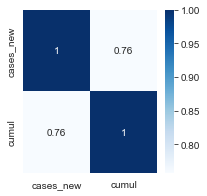

In [105]:
plt.figure(figsize=(3,3))
sns.heatmap(corr_merged_data_frame, annot=True,cmap='Blues')
plt.show()

From the heat map, we can see that the daily new cases positively correlate to each other. We plan to see the daily cases in each state but the result here is too confusing as we have 14 states. Hence we decided to plot out the graph individually to see the effect of the vaccine.

### Is there any correlation between vaccination and daily cases for Selangor, Sabah, Sarawak, and many more?
A naive way to answer this question is to find the correlation across the entire pandemic, but this does not take into account the time for the vaccines to start showing their effects. We try calculating the correlations only after a certain percentage of the population has been vaccinated.

In [72]:
# prepare a generic function that calculates the cumulative sum of cases and percentage vaccinated for each state with the option
# to remove a certain percentage of the data before doing so (something like alpha trimming)
'''
Inputs: state
Outputs: correlation matrix, dataframe of cumulative cases and percentage vaccinated
'''
def cases_vax_corr(state, mode = 1,percentage = 0):
    vax_state_temp = vax_state.copy()
    vax_state_temp = vax_state_temp[vax_state_temp['state'] == state]
    population_state = population[population['state'] == state]['pop'].iloc[0]
    vax_state_temp['cmul'] = vax_state_temp['daily_full'].cumsum()
    vax_state_temp['percentage_vaccinated'] = vax_state_temp['cmul'] / population_state

    state_cases = cases_state[cases_state['state'] == state]
    if mode == 2 :
        date = vax_state_temp[vax_state_temp['percentage_vaccinated'] >= percentage]['date'].iloc[0]
        state_cases = cases_state[cases_state['date'] >= date]
    state_vax = vax_state[vax_state['state'] == state]
    state_merged = state_cases.merge(state_vax, on='date')
    corr = state_merged[['daily', 'cases_new']].corr()
    
    return corr,vax_state_temp,state_merged

For each state, calculate the correlation after 5%, 10% and 15% of the population has been vaccinated. 

In [73]:
corr_selangor1,vax_percentage_selangor1,selangor_state_merged1 = cases_vax_corr('Selangor',1)
corr_selangor2,vax_percentage_selangor2,selangor_state_merged2 = cases_vax_corr('Selangor',2,0.05)
corr_selangor3,vax_percentage_selangor3,selangor_state_merged3 = cases_vax_corr('Selangor',2,0.10)
corr_selangor4,vax_percentage_selangor4,selangor_state_merged4 = cases_vax_corr('Selangor',2,0.15)
corr_sabah1,vax_percentage_sabah1,sabah_state_merged1 = cases_vax_corr('Sabah',1)
corr_sabah2,vax_percentage_sabah2,sabah_state_merged2 = cases_vax_corr('Sabah',2,0.05)
corr_sabah3,vax_percentage_sabah3,sabah_state_merged3 = cases_vax_corr('Sabah',2,0.15)
corr_sabah4,vax_percentage_sabah4,sabah_state_merged4 = cases_vax_corr('Sabah',2,0.2)
corr_sarawak1,vax_percentage_sarawak1,sarawak_state_merged1= cases_vax_corr('Sarawak',1)
corr_sarawak2,vax_percentage_sarawak2,sarawak_state_merged2= cases_vax_corr('Sarawak',2,0.05)
corr_sarawak3,vax_percentage_sarawak3,sarawak_state_merged3= cases_vax_corr('Sarawak',2,0.15)
corr_sarawak4,vax_percentage_sarawak4,sarawak_state_merged4= cases_vax_corr('Sarawak',2,0.2)

In [ ]:
table = {'Full Period':[corr_selangor1['daily']['cases_new'], corr_sabah1['daily']['cases_new'], corr_sarawak1['daily']['cases_new']],
        'When Vacinated Rate Over 0.05':[corr_selangor2['daily']['cases_new'], corr_sabah2['daily']['cases_new'], corr_sarawak2['daily']['cases_new']],
        'When Vacinated Rate Over 0.10':[corr_selangor3['daily']['cases_new'], corr_sabah3['daily']['cases_new'], corr_sarawak3['daily']['cases_new']],
        'When Vacinated Rate Over 0.15':[corr_selangor4['daily']['cases_new'], corr_sabah4['daily']['cases_new'], corr_sarawak4['daily']['cases_new']]}
 
# Creates pandas DataFrame.
table = pd.DataFrame(table, index =['Selangor','Sabah','Sarawak'])
table

,Full Period,When Vacinated Rate Over 0.05,When Vacinated Rate Over 0.10,When Vacinated Rate Over 0.15
Selangor,0.901396,0.036659,0.052980,0.086759
Sabah,0.870960,0.204788,0.169507,0.170766
Sarawak,-0.181897,-0.196554,-0.104347,-0.087613


Based on the table, we can see that the correlation between vaccination and daily cases changes drastically in different periods of the vaccination campaign, showing no noticeable pattern.

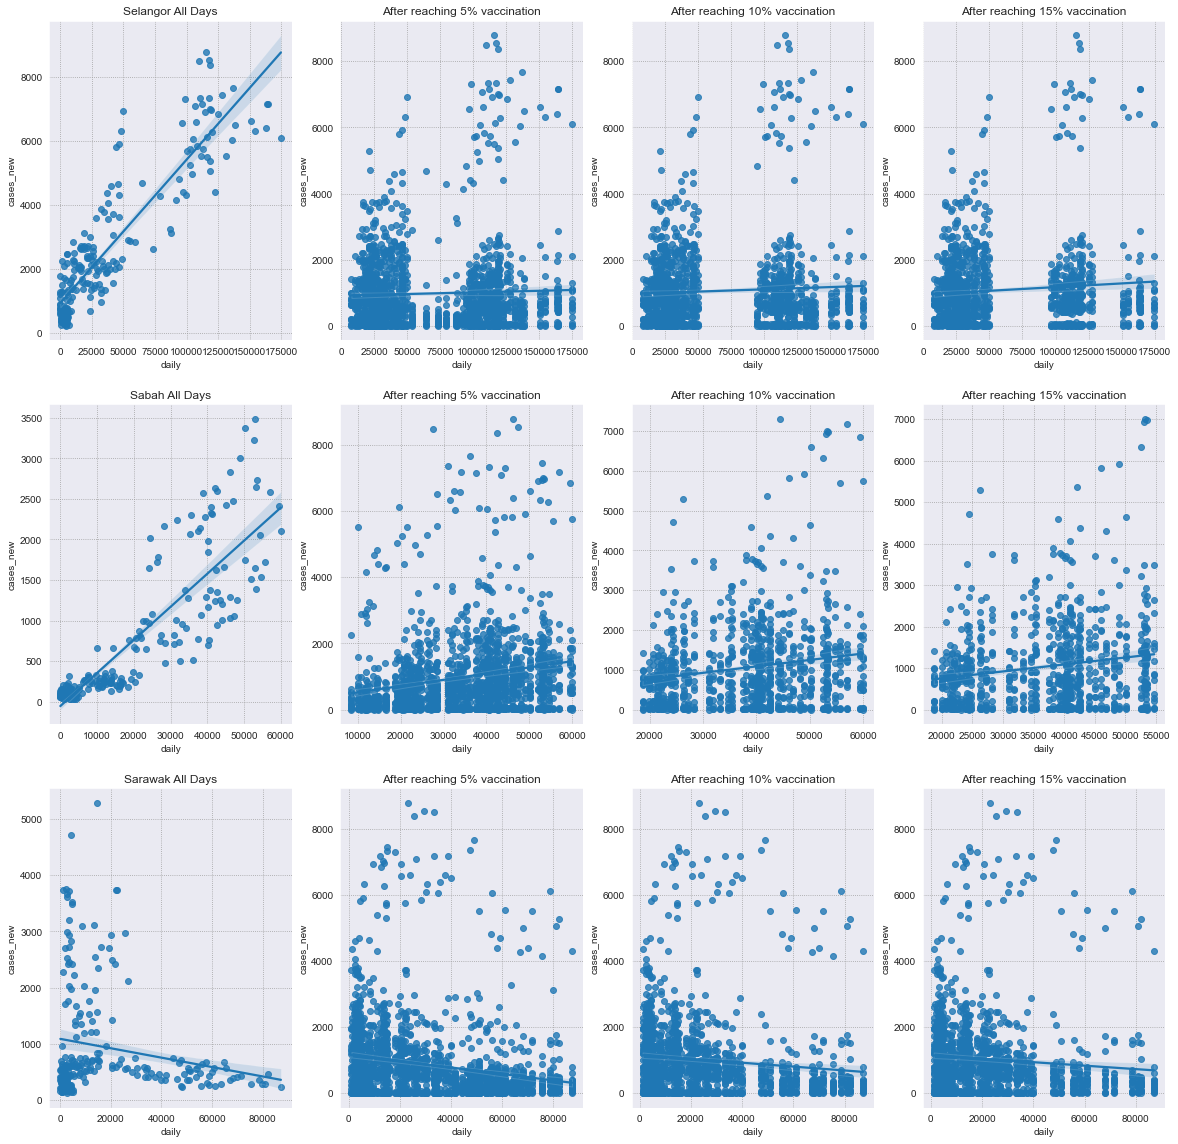

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(20, 20))
sns.regplot(x='daily', y='cases_new', data=selangor_state_merged1, ax=ax[0,0]).set(title='Selangor All Days')
sns.regplot(x='daily', y='cases_new', data=selangor_state_merged2, ax=ax[0,1]).set(title='After reaching 5% vaccination')
sns.regplot(x='daily', y='cases_new', data=selangor_state_merged3, ax=ax[0,2]).set(title='After reaching 10% vaccination')
sns.regplot(x='daily', y='cases_new', data=selangor_state_merged4, ax=ax[0,3]).set(title='After reaching 15% vaccination')
sns.regplot(x='daily', y='cases_new', data=sabah_state_merged1, ax=ax[1,0]).set(title='Sabah All Days')
sns.regplot(x='daily', y='cases_new', data=sabah_state_merged2, ax=ax[1,1]).set(title='After reaching 5% vaccination')
sns.regplot(x='daily', y='cases_new', data=sabah_state_merged3, ax=ax[1,2]).set(title='After reaching 10% vaccination')
sns.regplot(x='daily', y='cases_new', data=sabah_state_merged4, ax=ax[1,3]).set(title='After reaching 15% vaccination')
sns.regplot(x='daily', y='cases_new', data=sarawak_state_merged1, ax=ax[2,0]).set(title='Sarawak All Days')
sns.regplot(x='daily', y='cases_new', data=sarawak_state_merged2, ax=ax[2,1]).set(title='After reaching 5% vaccination')
sns.regplot(x='daily', y='cases_new', data=sarawak_state_merged3, ax=ax[2,2]).set(title='After reaching 10% vaccination')
sns.regplot(x='daily', y='cases_new', data=sarawak_state_merged4, ax=ax[2,3]).set(title='After reaching 15% vaccination')
plt.show()

Show a linechart through the entire vaccination campaign to see which state's vaccination campaign is superior to the others. 

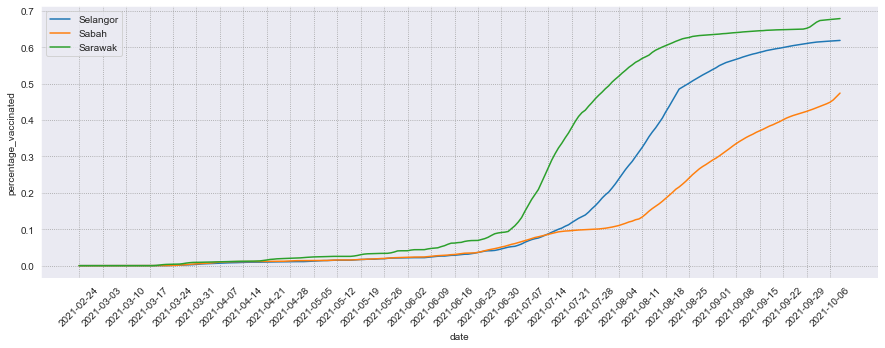

In [72]:
plt.figure(figsize=(15, 5))
sns.lineplot(x='date', y='percentage_vaccinated', data=vax_percentage_selangor1, label='Selangor')
sns.lineplot(x='date', y='percentage_vaccinated', data=vax_percentage_sabah1, label='Sabah')
sns.lineplot(x='date', y='percentage_vaccinated', data=vax_percentage_sarawak1, label='Sarawak')
plt.xticks([i for i in range(0, len(vax_percentage_selangor1), 7)], vax_percentage_selangor1['date'].iloc[::7], rotation=45)
plt.legend()

From the line chart, Sarawak seems to be superior, but the correlation table just now did not show it's impact. We can conclude that when the vaccination rate reaches a certain point, the correlation between vaccination rate of the state and daily new cases virtually hits 0.

### Which states have been most affected by Covid clusters? (e.g. Kluster Mahkamah, Court Cluster, etc.)

To answer this question, we first split the "states" column into individual states and explode the dataframe. Some Covid clusters span across multiple states, so we have to do this to understand how much the cases of each state are affected by entire clusters.

In [74]:
# iterate row by row through clusters dataframe
import re
clusters['single_state'] = clusters['state'].apply(lambda x: [state.strip().title() for state in re.split(', | & ', x)])
clusters_singlestate = clusters.explode('single_state')
clusters_singlestate = clusters_singlestate[clusters_singlestate['single_state'].isin(['Wp Kuala Lumpur', 'Wp Putrajaya', 'Selangor', 'Negeri Sembilan', 'Pahang', 'Johor', 'Sarawak', 'Kedah', 'Perak', 'Kelantan'])]

In [75]:
clusters_singlestate['cases_total'].describe()

count    5132.000000
mean      112.030398
std       364.416899
min         2.000000
25%        19.000000
50%        38.000000
75%        86.000000
max      7205.000000
Name: cases_total, dtype: float64

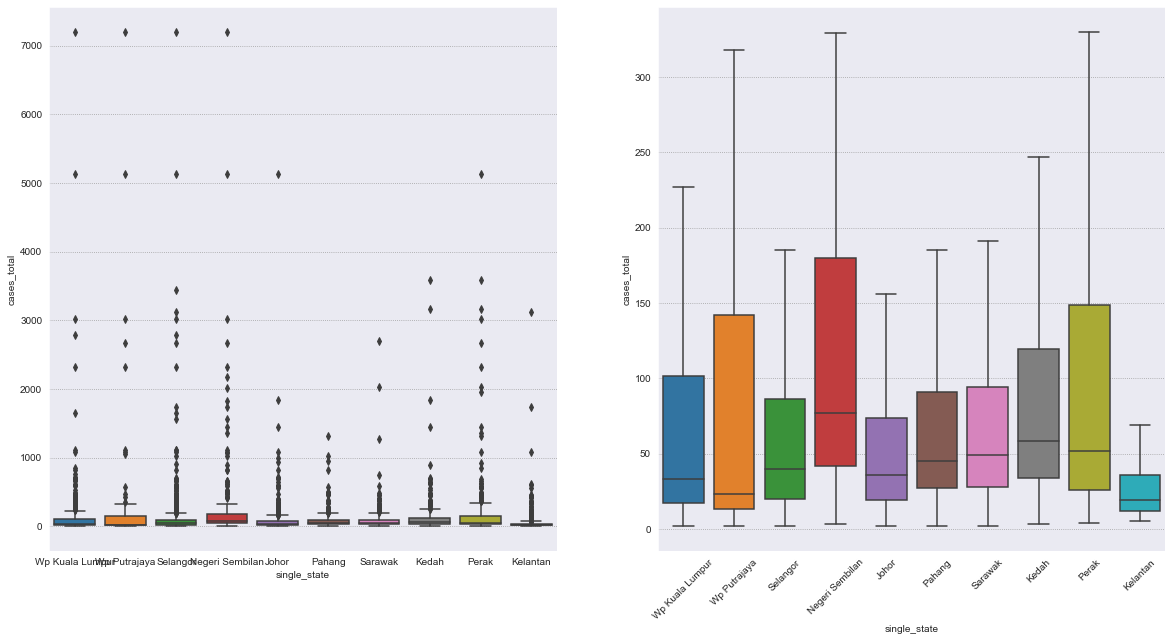

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
plt.xticks(rotation=45)
sns.boxplot(x='single_state', y='cases_total', data=clusters_singlestate, ax=ax[0])
sns.boxplot(x='single_state', y='cases_total', data=clusters_singlestate, showfliers=False, ax=ax[1])
plt.show()

We can see from the boxplot that the majority of Covid Clusters are moderately sized, often under 100 cases per cluster. However, there does exist unusually large clusters that appear as outliers. 

In this case, to get a more meaningful idea of "ordinary" clusters alone, we remove the outliers and show a new boxplot. Surprisingly, Negeri Sembilan and Perak are most affected by clusters, as opposed to more populated states like Selangor or Kuala Lumpur.

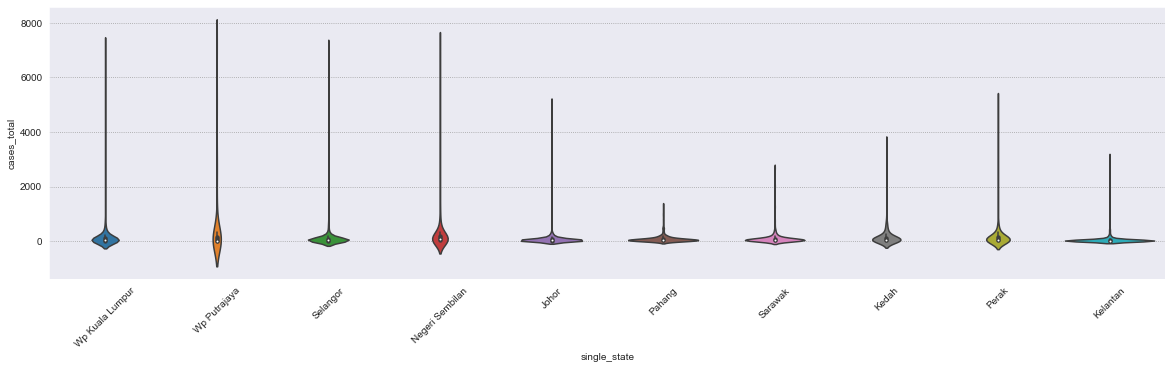

In [78]:
plt.figure(figsize=(20, 5))
sns.violinplot(x='single_state', y='cases_total', data=clusters_singlestate)
plt.xticks(rotation=45)
plt.show()

The violin plot shows us the relative Covid cluster sizes in each state. States like Selangor, Johor, Pahang and Sarawak have mostly small clusters, while Putrajaya and Negeri Sembilan are narrower and have a wide range of cluster sizes, ranging from just a few people to 1000 people. Putrajaya's and Negeri Sembilan's shape is unsurprising, as the earlier boxplot showed just how impactful Covid-19 clusters are in these regions. 

### What type of Covid-19 clusters are most prevalent? Are these clusters forming in workplaces, night markets or schools?

<AxesSubplot:xlabel='category', ylabel='cases_total'>

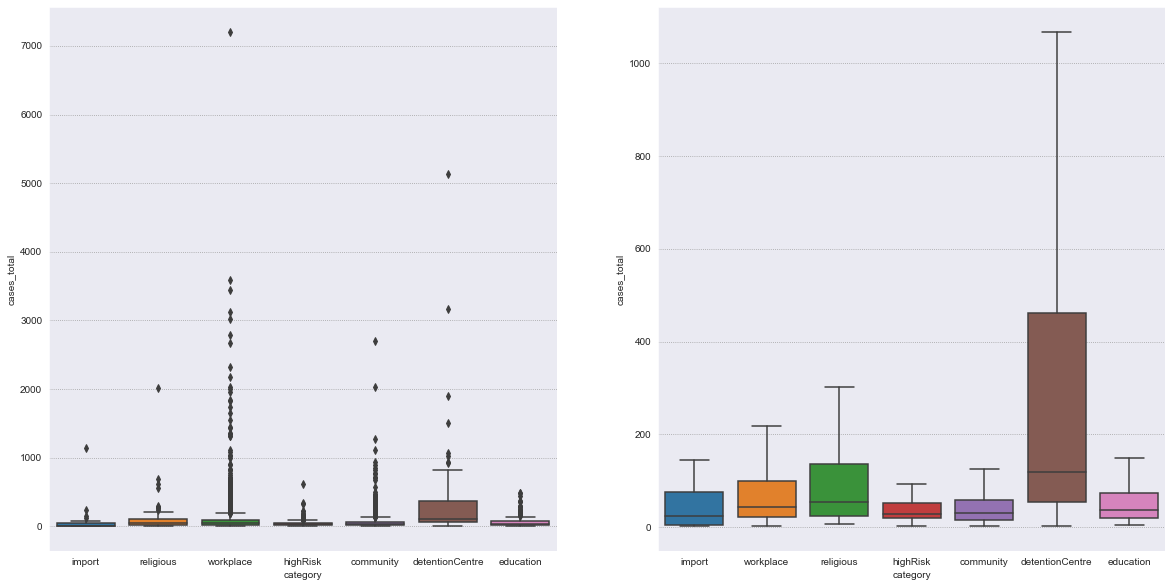

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.boxplot(x='category', y='cases_total', data=clusters, ax=ax[0])
sns.boxplot(x='category', y='cases_total', data=clusters_singlestate, showfliers=False, ax=ax[1])

The detention centers generally have the largest Covid clusters, with a strong right skew. The rest of the cluster categories have mostly small clusters, but as we observed in the earlier question, there are quite a few unusually large clusters. 

An interesting example is workplace clusters. For instance, most companies/organisations in Malaysia are small, so there may be a **high frequency** of clusters, but only some are **large enough** to appear as an outlier. Case in point, Top Glove.

### How well is Malaysia's vaccination campaign doing compared to other countries in South-East Asia 🌎 ?

To answer this question, we import and clean 🌎 Covid datasets.

In [77]:
global_datasets =  pd.read_csv('./global_datasets/owid-covid-data.csv')
global_datasets

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124194,ZWE,Africa,Zimbabwe,2021-10-12,132016.0,141.0,115.857,4645.0,2.0,2.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
124195,ZWE,Africa,Zimbabwe,2021-10-13,132108.0,92.0,96.286,4648.0,3.0,2.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
124196,ZWE,Africa,Zimbabwe,2021-10-14,132251.0,143.0,104.000,4655.0,7.0,3.429,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
124197,ZWE,Africa,Zimbabwe,2021-10-15,132285.0,34.0,82.857,4655.0,0.0,3.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [82]:
global_datasets.fillna(0, inplace=True)
global_datasets.drop_duplicates(inplace=True)

In [83]:
# remove unnecessary columns
global_datasets.drop(columns=['iso_code', 'continent','new_cases_smoothed','new_deaths_smoothed','new_cases_smoothed_per_million',
                              'new_deaths_smoothed_per_million','reproduction_rate','icu_patients','icu_patients_per_million','hosp_patients',
                              'hosp_patients_per_million','weekly_icu_admissions','weekly_icu_admissions_per_million','weekly_hosp_admissions',
                              'weekly_hosp_admissions_per_million','new_tests_smoothed','total_boosters','new_vaccinations_smoothed',
                              'total_boosters_per_hundred','new_vaccinations_smoothed_per_million','stringency_index','median_age',
                              'aged_65_older','aged_70_older','gdp_per_capita','extreme_poverty','cardiovasc_death_rate','diabetes_prevalence',
                              'female_smokers','male_smokers','handwashing_facilities','hospital_beds_per_thousand','life_expectancy','human_development_index',
                              'excess_mortality_cumulative_absolute','excess_mortality_cumulative','excess_mortality','excess_mortality_cumulative_per_million',
                             ], inplace=True)
global_datasets.head()

,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,...,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,population,population_density
0,Afghanistan,2020-02-24,5.0,5.0,0.0,0.0,0.126,0.126,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
1,Afghanistan,2020-02-25,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
2,Afghanistan,2020-02-26,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
3,Afghanistan,2020-02-27,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
4,Afghanistan,2020-02-28,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422


In [84]:
# define a function to return vaccination data beyond a certain date
# we choose April 2021 because this is when Malaysia's 🇲🇾 vaccination campaign kicked off
def getCountry(country) :
    filter = global_datasets['location'] == country
    df = global_datasets[filter]
    df = df[['date','population','people_fully_vaccinated']]
    df['cumul'] = df['people_fully_vaccinated'].cumsum()
    df['percentage_vaccinated'] = df['cumul'] / df['population']
    filter2 = df['date'] > '2021-04'
    df = df[filter2]
    return df

In [85]:
# get vaccination data for each country
Brunei = getCountry('Brunei')
Myanmar = getCountry('Myanmar')
Cambodia = getCountry('Cambodia')
Indonesia = getCountry('Indonesia')
Laos = getCountry('Laos')
Malaysia = getCountry('Malaysia')
Philippines = getCountry('Philippines')
Singapore = getCountry('Singapore')
Thailand = getCountry('Thailand')
Vietnam = getCountry('Vietnam')

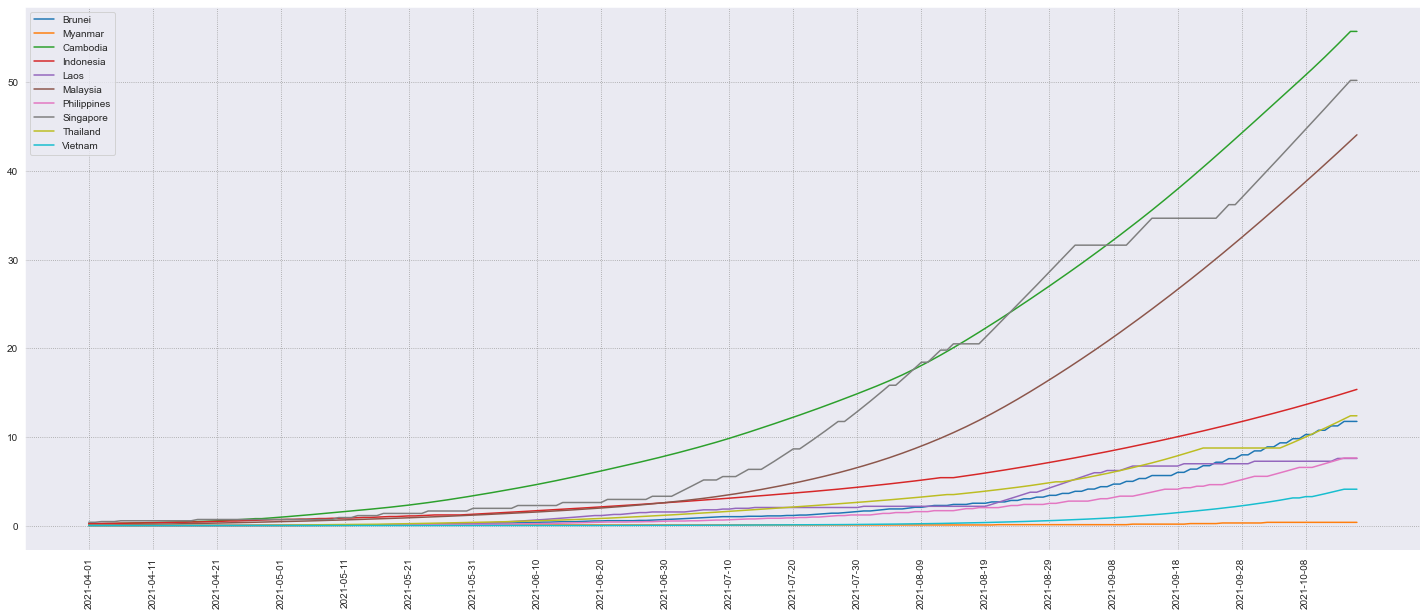

In [86]:
# plot line charts of the vaccination rate of each country
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(Brunei['date'], Brunei['percentage_vaccinated'], label = "Brunei")
ax.plot(Myanmar['date'], Myanmar['percentage_vaccinated'], label = "Myanmar")
ax.plot(Cambodia['date'], Cambodia['percentage_vaccinated'], label = "Cambodia")
ax.plot(Indonesia['date'], Indonesia['percentage_vaccinated'], label = "Indonesia")
ax.plot(Laos['date'], Laos['percentage_vaccinated'], label = "Laos")
ax.plot(Malaysia['date'], Malaysia['percentage_vaccinated'], label = "Malaysia")
ax.plot(Philippines['date'], Philippines['percentage_vaccinated'], label = "Philippines")
ax.plot(Singapore['date'], Singapore['percentage_vaccinated'], label = "Singapore")
ax.plot(Thailand['date'], Thailand['percentage_vaccinated'], label = "Thailand")
ax.plot(Vietnam['date'], Vietnam['percentage_vaccinated'], label = "Vietnam")
ax.set_xticks(ax.get_xticks()[::10])
ax.tick_params(axis='x', labelrotation=90)
ax.legend()

The line graph above shows that the vaccination rate for each country in South-East Asia. Based on the result, we can see that Cambodia has the highest vaccination rate compared to other countries. For Malaysia, we ranked top 3 in the graph and the vaccinated rate is near 45%. Hence, we can conclude that Malaysia's vaccination campaign is doing better than the majority of South-East Asia's countries.

**Note: Percentages are on the low end maybe because this dataset is a few weeks old. When countries are vaccinating thousands a day, the percentage will be higher.**

Even still, Malaysia is doing statistically better than other ASEAN nations.

### Is there a correlation between individual casual contacts (contact tracing) and daily cases? If the link is strong, how contagious is Covid-19?

We correlated individual daily contacts with cases.

In [90]:
trace_malaysia

,date,casual_contacts,hide_large,hide_small
0,2021-03-01,7847,NaN,NaN
1,2021-03-02,6419,NaN,NaN
2,2021-03-03,6903,NaN,NaN
3,2021-03-04,7000,NaN,NaN
4,2021-03-05,9152,NaN,NaN
...,...,...,...,...
216,2021-10-03,32301,37.0,604.0
217,2021-10-05,37312,39.0,841.0
218,2021-10-06,34444,45.0,782.0
219,2021-10-07,39312,43.0,820.0


In [93]:
temp_cases_malaysia = cases_malaysia.copy()
temp_trace_malaysia = trace_malaysia.copy()

<AxesSubplot:>

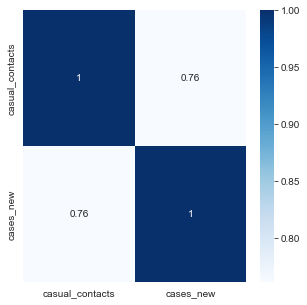

In [95]:
merged = temp_cases_malaysia.merge(temp_trace_malaysia, on='date')
corr = merged[['casual_contacts', 'cases_new']].corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True,cmap='Blues')

<AxesSubplot:xlabel='casual_contacts', ylabel='cases_new'>

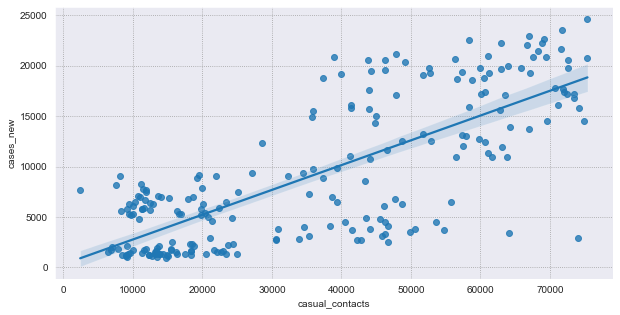

In [97]:
plt.figure(figsize=(10,5))
sns.regplot(x='casual_contacts', y='cases_new', data=merged)

Based on both the heatmap and the regression plot, we can see that daily new cases are highly correlated with the number of casual contacts for the day. As in, if more people go out and come in close contact with infected people, the number of cases increases. The statistics fall in line with the science behind Covid-19 🦠.

<img src="./social-distancing.gif">

### How has the vaccination rate changed over time across states?

We first normalize both the vaccination rate(%) and the daily new cases of covid cases to see if there's any effect of vaccination. We specifically look at the top 5 states that require more attention( Melaka, Negeri Sembilan, Perlis, Selangor and W.P. Putrajaya) that we found out that have low vaccination rate in the earlier finding.

In [106]:
grouped_malaysia_cases = malaysia_cases.groupby(['date','state']).sum().reset_index()

grouped_malaysia_cases.head()
#fig, ax = plt.subplots(figsize=(15,7))
#grouped = malaysia_cases.groupby(['date','state']).sum().unstack().plot(ax=ax)

,date,state,cases_new
0,2020-01-25,Johor,4
1,2020-01-25,Kedah,0
2,2020-01-25,Kelantan,0
3,2020-01-25,Melaka,0
4,2020-01-25,Negeri Sembilan,0


In [108]:
vax_state = vax_state[['date','state','daily_full']]
merged_vax_state = pd.merge(vax_state, malaysia_cases, on=['date','state'])
merged_vax_state

,date,state,daily_full,cases_new
0,2021-02-24,Johor,0,318
1,2021-02-24,Kedah,0,17
2,2021-02-24,Kelantan,0,53
3,2021-02-24,Melaka,0,26
4,2021-02-24,Negeri Sembilan,0,1392
...,...,...,...,...
3643,2021-10-09,Selangor,3877,1351
3644,2021-10-09,Terengganu,3711,590
3645,2021-10-09,W.P. Kuala Lumpur,1119,288
3646,2021-10-09,W.P. Labuan,414,1


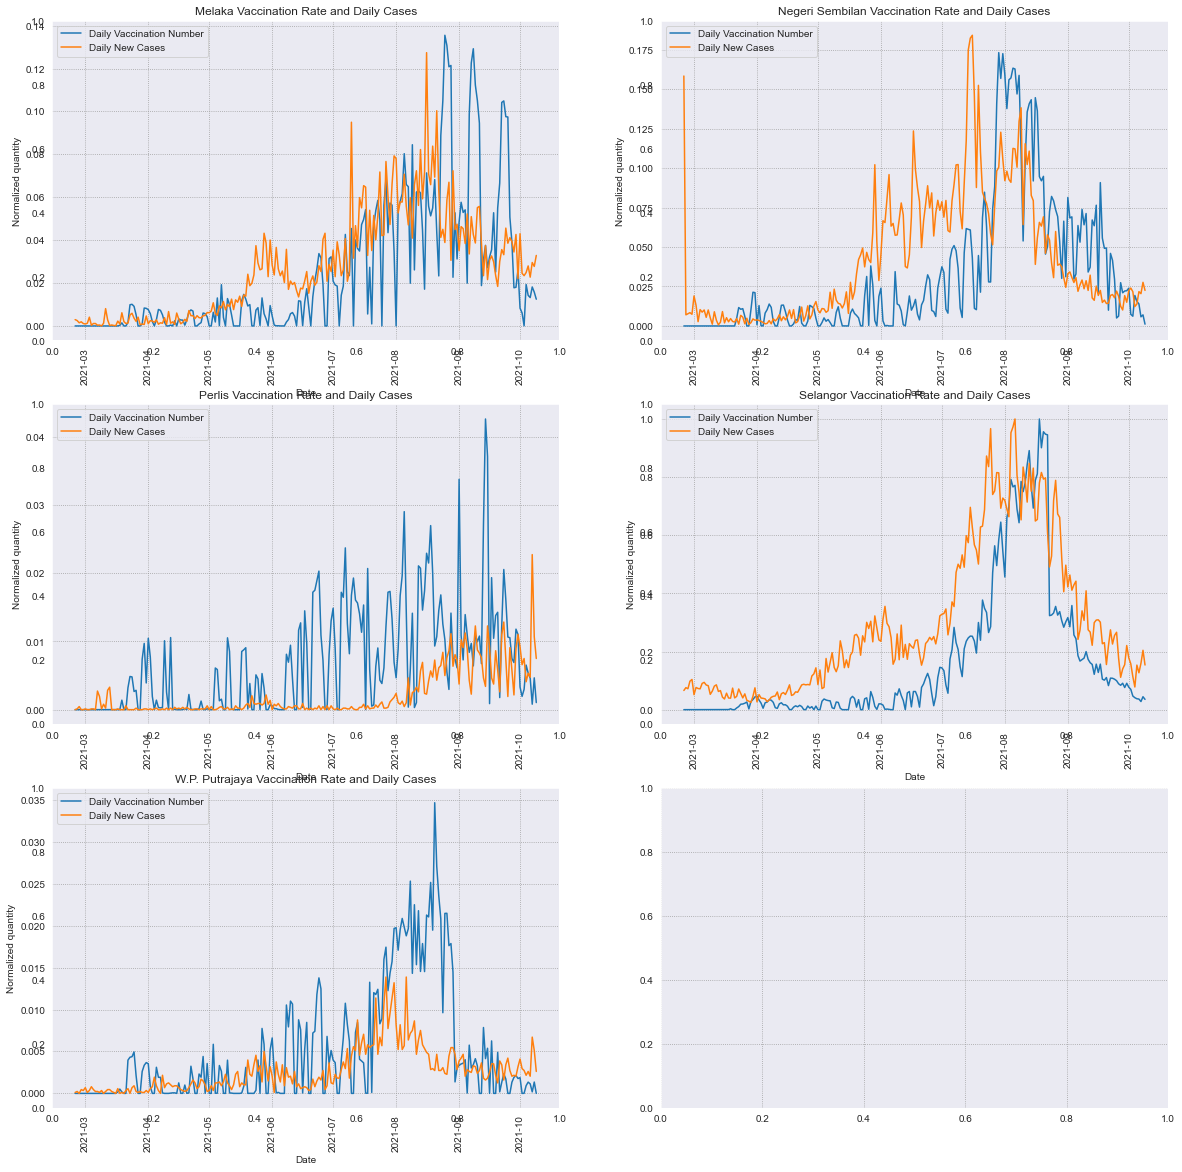

In [110]:
from sklearn import preprocessing
import matplotlib.pyplot as plt

#states = ['Johor','Kedah','Kelantan','Melaka','Negeri Sembilan','Pahang','Perak','Perlis','Pulau Pinang','Sabah',
#          'Sarawak','Selangor','Terengganu','W.P. Kuala Lumpur','W.P. Labuan','W.P. Putrajaya']

states = ['Melaka','Negeri Sembilan','Perlis','Selangor','W.P. Putrajaya']

scaler = preprocessing.MinMaxScaler()
names = ['cases_new','daily_full']
d = scaler.fit_transform(merged_vax_state[['cases_new','daily_full']])
scaled_df = pd.DataFrame(d, columns=names)
scaled_df['date'] = pd.to_datetime(merged_vax_state['date'])
scaled_df['state'] = merged_vax_state['state']

fig, axes = plt.subplots(3, 2, figsize=(20,20))

#scaled_df[scaled_df['state']==i]['date'],
for index, i in enumerate(states):
    ax = fig.add_subplot(3, 2, index + 1)
    ax.plot(scaled_df[scaled_df['state']==i]['date'],scaled_df[scaled_df['state']==i]['daily_full'],label = "Daily Vaccination Number")
    ax.plot(scaled_df[scaled_df['state']==i]['date'],scaled_df[scaled_df['state']==i]['cases_new'],label = "Daily New Cases")
    plt.xticks(rotation=90)
    plt.title(i + ' Vaccination Rate and Daily Cases')
    plt.xlabel('Date')
    plt.ylabel('Normalized quantity')
    leg = plt.legend(loc='upper left')

plt.show()

 As we can see from the line graph that we plot out, it is clear that when the government put more effort into getting the people vaccinated in that certain state, the daily cases would start to decline, except for Perlis. Perlis's daily cases spikes up a little in October 2021 but not drastically. We can safely assume that vaccination actually in a way help controlling the cluster cases in Perlis without going higher. Regardless, we can conclude that vaccination might be one of the contributing factor to reduce daily covid cases in Malaysia. However, more research is needed in order to conclude this finding. 

### How has the vaccination rate changed across the nation?

We make a new dataframe to store the cumulative population that have already get their full vaccination then, and a new column to store the percentage of the population which is derrived from the cumulative population. Lastly we plot out a line graph to visualize the vaccination rate across the whole Malaysia

In [111]:
vax_pop_percentage = vax_malaysia['cumul']
vax_pop_percentage = pd.DataFrame(vax_pop_percentage)
vax_pop_percentage['percentage'] = vax_pop_percentage.apply(lambda x: (vax_malaysia['cumul']/population[population['state']=='Malaysia']['pop'].item())*100,axis=0)
vax_pop_percentage['date'] = pd.to_datetime(vax_malaysia['date'])
vax_pop_percentage

,cumul,percentage,date
0,0,0.000000,2021-02-24
1,0,0.000000,2021-02-25
2,1,0.000003,2021-02-26
3,2,0.000006,2021-02-27
4,5,0.000015,2021-02-28
...,...,...,...
223,20819254,63.750495,2021-10-05
224,20915720,64.045882,2021-10-06
225,21004275,64.317046,2021-10-07
226,21104896,64.625157,2021-10-08


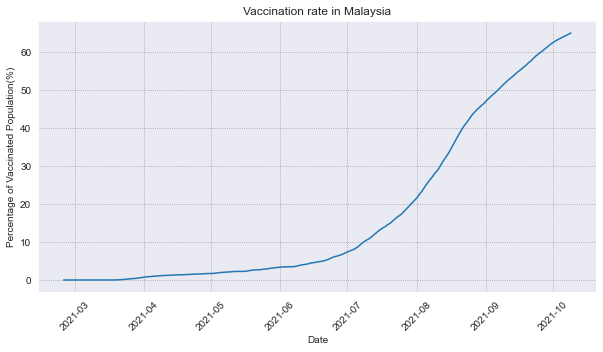

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.lineplot(x='date', y='percentage', data=vax_pop_percentage)
plt.xlabel('Date')
plt.ylabel('Percentage of Vaccinated Population(%)')
plt.xticks(rotation=45)
plt.title('Vaccination rate in Malaysia')
plt.show()

If we consider the population of Malaysia as a whole, we have just crossed the 60% vaccination threshold. There does seem to be a slow start, but the speed of the campaign has picked up.

### Which vaccines 💉 have been used the most? 
There has been a lot of debate about this. Malaysia is one of few countries that chooses to buy a variety of vaccines and even switched from Sinovac to Pfizer in the middle of the campaign, so it is interesting to see which vaccines were used to inoculate the majority of the population and their general daily adoption.

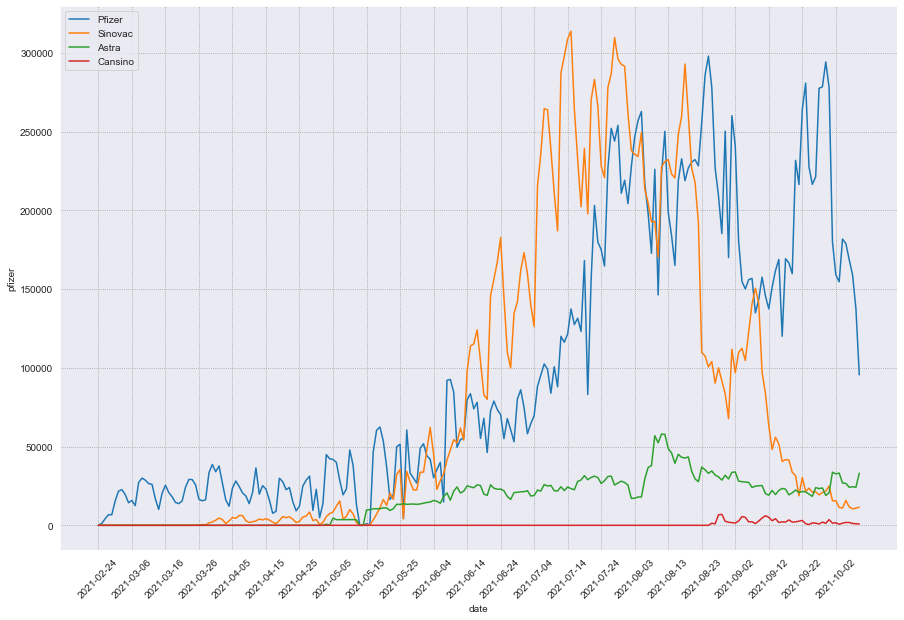

In [112]:
plt.figure(figsize=(15, 10))
sns.lineplot(x='date', y='pfizer', data=vax_malaysia_all_attributes)
sns.lineplot(x='date', y='sinovac', data=vax_malaysia_all_attributes)
sns.lineplot(x='date', y='astra', data=vax_malaysia_all_attributes)
sns.lineplot(x='date', y='cansino', data=vax_malaysia_all_attributes)
# only show some xtick labels
plt.xticks([date for i, date in enumerate(vax_malaysia_all_attributes['date']) if i % 10 == 0], rotation=45)
plt.legend(['Pfizer', 'Sinovac', 'Astra', 'Cansino'])
plt.show()

At the start of the campaign, MoH was primarily using Pfizer, but by June, Sinovac would rapidly overtake Pfizer to become the most used vaccine. Adoption of Sinovac however drops, but people still do come back for their second dose. 

<img src="./sinovac-phaseout.png" width=300>
<br/>
<a href="https://thediplomat.com/2021/07/malaysia-to-phase-out-chinas-sinovac-vaccine/">Link</a>

In [113]:
vaccine_totals = pd.DataFrame(vax_malaysia_all_attributes[['pfizer', 'astra', 'sinovac']].sum().reset_index())
vaccine_totals.columns = ['vaccine', 'total']
vaccine_totals

,vaccine,total
0,pfizer,22755674
1,astra,3714440
2,sinovac,18737007


<AxesSubplot:xlabel='vaccine', ylabel='total'>

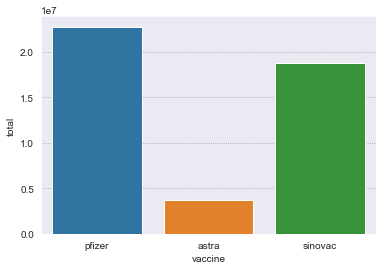

In [114]:
sns.barplot(x='vaccine', y='total', data=vaccine_totals)

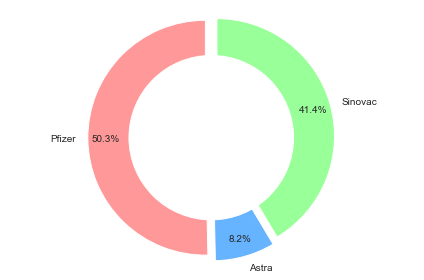

In [115]:
# pie chart of vaccine_totals
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.05, 0.05, 0.05)
fig1, ax1 = plt.subplots()
ax1.pie(vaccine_totals['total'], labels=vaccine_totals['vaccine'].str.title(), colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')
plt.tight_layout()
plt.show()

Pfizer is the most used vaccine in Malaysia, followed by Sinovac and then Astrazeneca. If you observe the usage of Astrazeneca, it flails in comparison to the other two because it was opened up for voluntary registrations. Furthermore, unlike Pfizer and Sinovac, Astrazeneca usage does not show an upward trend and only has a few spikes, which may be attributed to the government opening up registrations.


## Clustering

### How did the clusters change over time with respect to cases and deaths? Did some states reorganise into new clusters?

Each cluster point is considered as one state. 

In [120]:
states = vax_state['state'].unique()

#### KMeans

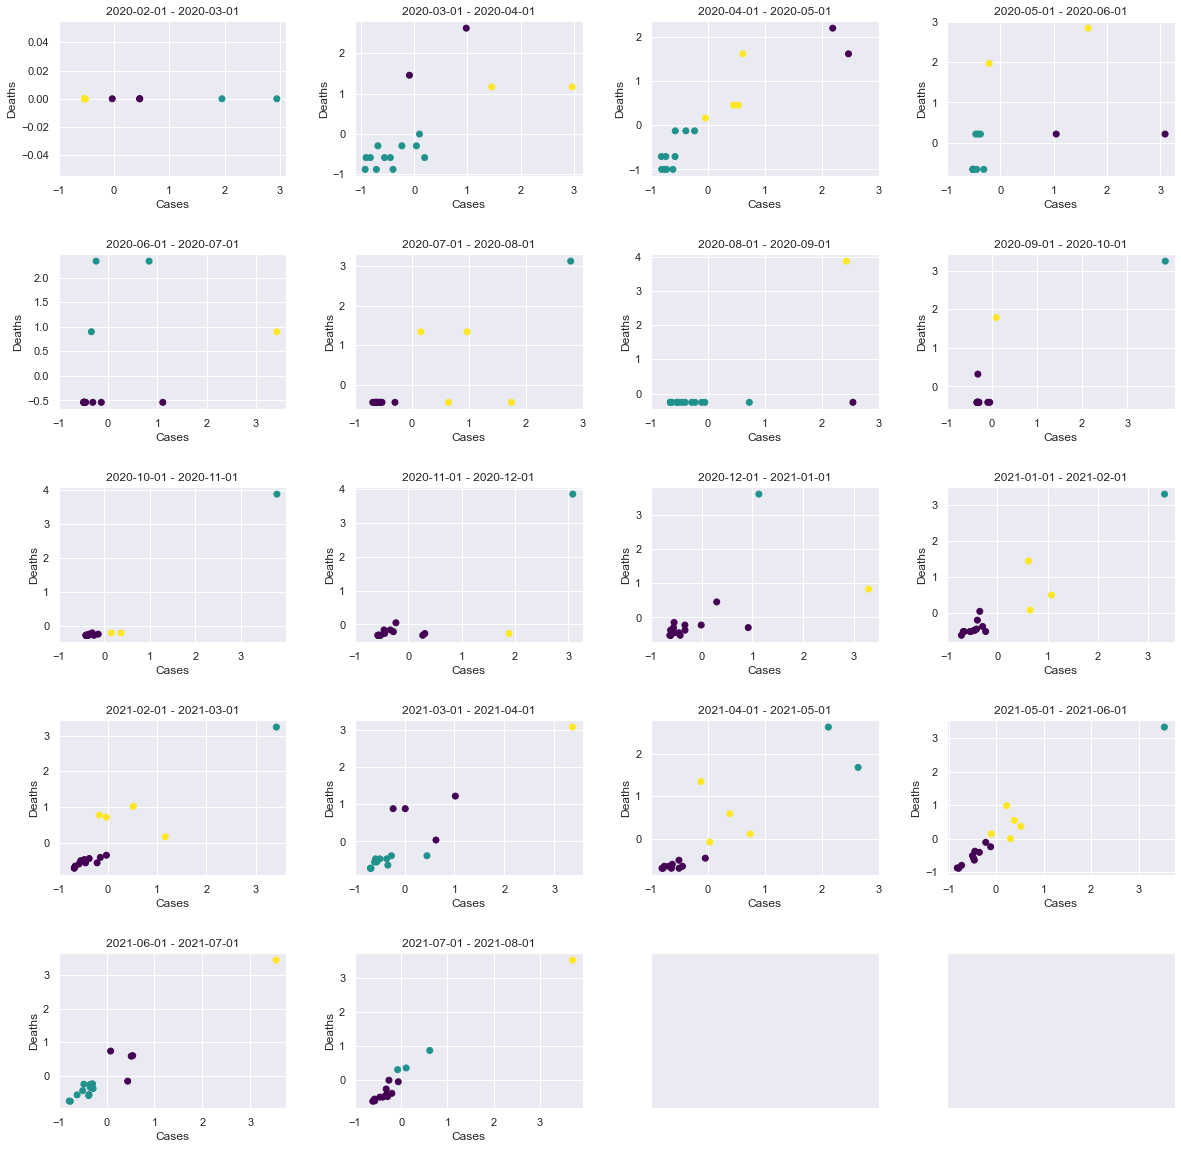

In [121]:
sns.set(rc={'figure.figsize':(18, 3)})
nrows = 5
ncols = 4
fig, axes = plt.subplots(5, 4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 20):
    grid_combos.append((nrows, ncols, i))

dates = ['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    
    cases = []
    vaccinations = []
    deaths = []

    for state in states:
        cases.append(cases_state_date[cases_state_date['state'] == state]['cases_new'].sum())
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum())

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths})
    for col in cases_deaths_vaccinations:
        if cases_deaths_vaccinations[col].dtype != 'object':
            cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations

    km = KMeans(n_clusters=3, max_iter=100)
    y_clusters = km.fit_predict(cases_deaths_vaccinations)
    centroids = km.cluster_centers_

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num)
    ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Cases')
    ax.set_ylabel('Deaths')
    ax.set_xticks(np.arange(-1, 4, 1))
    # ax.set_yticks(np.arange(-0.05, 3.5, 0.5))
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

#### DBSCAN

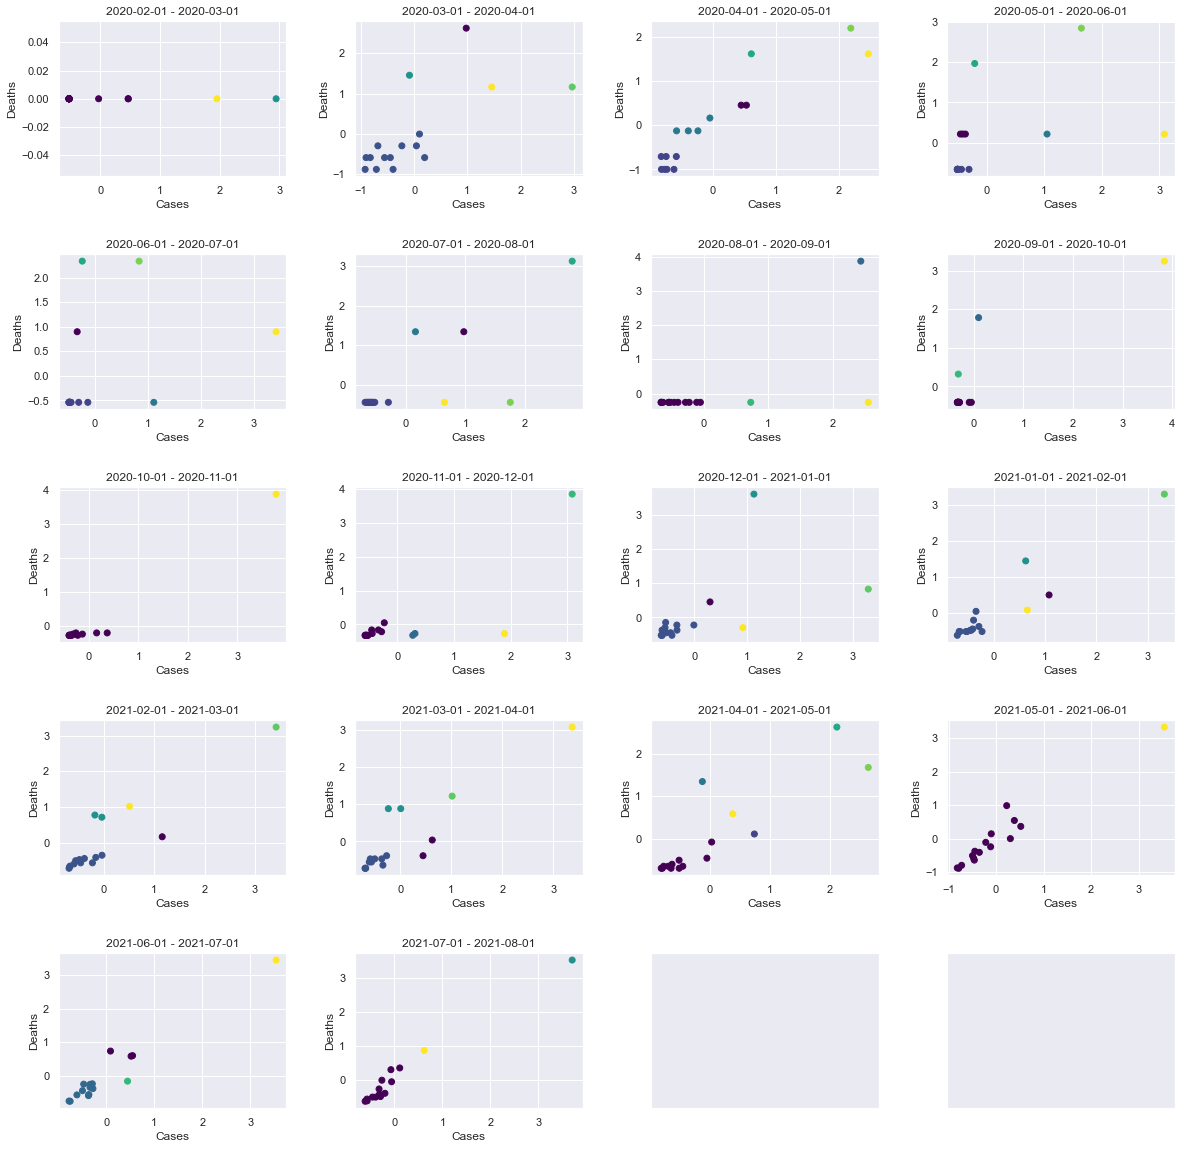

In [122]:
nrows = 5
ncols = 4
fig, axes = plt.subplots(5, 4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 20):
    grid_combos.append((nrows, ncols, i))

dates = ['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    
    cases = []
    vaccinations = []
    deaths = []

    for state in states:
        cases.append(cases_state_date[cases_state_date['state'] == state]['cases_new'].sum())
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum())

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths})
    for col in cases_deaths_vaccinations:
        if cases_deaths_vaccinations[col].dtype != 'object':
            cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations

    dbscan = DBSCAN(eps=0.5, min_samples=1).fit(cases_deaths_vaccinations)
    y_clusters = dbscan.fit_predict(cases_deaths_vaccinations)

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num)
    ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Cases')
    ax.set_ylabel('Deaths')
    # ax.set_xticks(np.arange(-1, 4, 1))
    # ax.set_yticks(np.arange(-0.05, 3.5, 0.5))
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

We can observe that in the beginning, the majority of the clusters were positioned towards the bottom left and they maintain a similar pattern until about August 2020. In August, the cases were still high but there were fewer deaths, which may signify that the situation was improving, besides the one state that is in the upper corner of the plot that stands out from the rest. Around December, the bottom-right cluster begins to break up and states start moving diagonally upwards in the graph, meaning higher number of deaths and more cases. By September 2021, the states fall in a sort of straight diagonal line, with the performance of states spread across the spectrum from mild to serious. 

We also set out to find that one state that created a cluster of it's own throughout and it was Selangor, to no one's surprise.

### Do the performance of states based on total cases, deaths and vaccinations form any clusters?

To answer this question, we will try several types of clustering:
* 3-dimensional clustering between cases, deaths and vaccinations treating each point on the graph as a state
    * K-Means 

We use Standard Scaler to scale the data before performing all clustering.

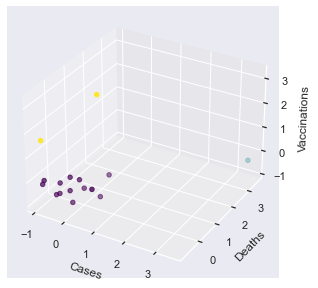

In [586]:
states = list(cases_state['state'].unique())

cases = []
vaccinations = []
deaths = []

for state in states:
    cases.append(cases_state[cases_state['state'] == state]['cases_new'].sum())
    deaths.append(deaths_state[deaths_state['state'] == state]['deaths_new'].sum())
    vaccinations.append(vax_state[deaths_state['state'] == state]['daily_full'].sum() / population.loc[population['state'] == state, 'pop'].values[0])

cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths, "vaccinations": vaccinations})
for col in cases_deaths_vaccinations:
    if cases_deaths_vaccinations[col].dtype != 'object':
        cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

states_column = cases_deaths_vaccinations['state']
cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
X_std = cases_deaths_vaccinations

km = KMeans(n_clusters=3, max_iter=100)
y_clusters = km.fit_predict(cases_deaths_vaccinations)
centroids = km.cluster_centers_

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], cases_deaths_vaccinations['vaccinations'], c=y_clusters, cmap='viridis')
ax.set_xlabel('Cases')
ax.set_ylabel('Deaths')
ax.set_zlabel('Vaccinations')
plt.show()

In [114]:
cases_deaths_vaccinations['predictions'] = y_clusters
cases_deaths_vaccinations['state'] = states_column
cases_deaths_vaccinations

,cases,deaths,vaccinations,predictions,state
0,0.376115,0.779508,1.018159,0,Johor
1,-0.036383,0.087040,-0.094470,0,Kedah
2,-0.135631,-0.370070,-0.402749,2,Kelantan
3,-0.543889,-0.380046,-0.695190,2,Melaka
4,-0.299397,-0.226769,-0.504680,2,Negeri Sembilan
5,-0.483369,-0.496591,-0.367193,2,Pahang
6,-0.237798,-0.338326,0.152994,0,Perak
7,-0.901673,-0.733309,-1.121005,2,Perlis
8,-0.060205,-0.110678,-0.100764,0,Pulau Pinang
9,0.378025,0.287026,0.510771,0,Sabah


The 3-dimensional graph is quite hard to interpret, but we can observe 3 main clusters forming, which are:
1. Low cases and low deaths
2. Low cases and High deaths
3. High cases, High deaths and High vaccinations

With no surprise, the third cluster with high cases, deaths and vaccination rates is Selangor.

To get better insights, we remove the third dimension (vaccinations) temporarily and cluster only based on cases and deaths.

### How did the clusters change over time with respect to cases, deaths and vaccinations? Did some states reorganise into new clusters?

In this question, we bring in a third factor: vaccinations.

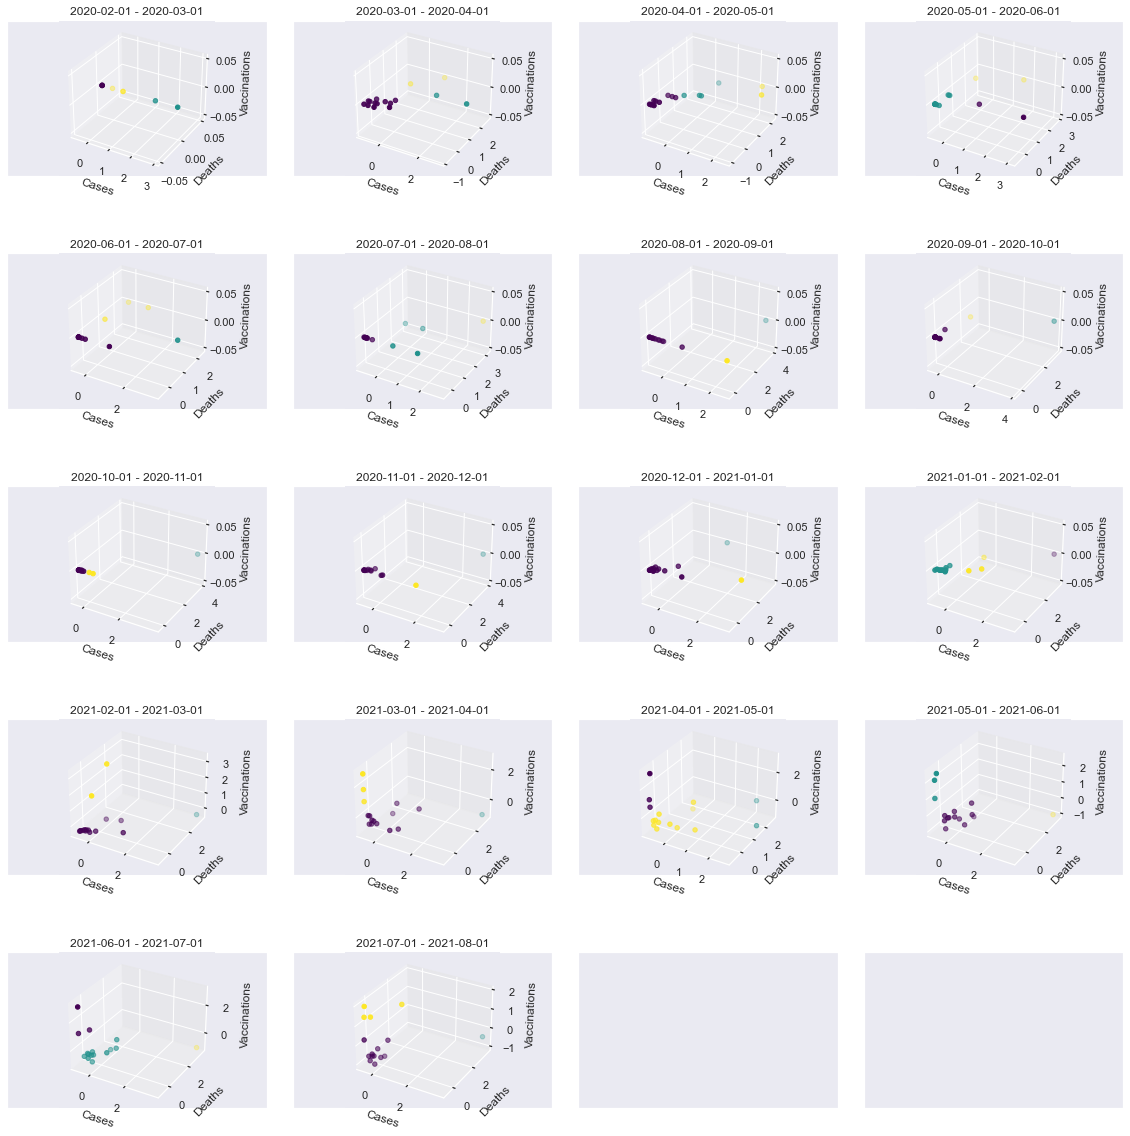

In [593]:
sns.set(rc={'figure.figsize':(18, 3)})
nrows = 5
ncols = 4
fig, axes = plt.subplots(5, 4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 20):
    grid_combos.append((nrows, ncols, i))

dates = ['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    vax_state_date = vax_state[(vax_state['date'] < date_range[1])]
    
    cases = []
    vaccinations = []
    deaths = []

    for state in states:
        cases.append(cases_state_date[cases_state_date['state'] == state]['cases_new'].sum())
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum())
        vaccinations.append(vax_state_date[vax_state_date['state'] == state]['daily_full'].sum() / population.loc[population['state'] == state, 'pop'].values[0])

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths, "vaccinations": vaccinations})
    for col in cases_deaths_vaccinations:
        if cases_deaths_vaccinations[col].dtype != 'object':
            cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations
    
    km = KMeans(n_clusters=3, max_iter=100)
    y_clusters = km.fit_predict(cases_deaths_vaccinations)
    centroids = km.cluster_centers_

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num, projection='3d')
    ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], cases_deaths_vaccinations['vaccinations'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Cases')
    ax.set_ylabel('Deaths')
    ax.set_zlabel('Vaccinations')
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

We maintain that states can be grouped into 3 clusters. Throughout 2020, vaccinations are 0 and hence, the clusters slowly start to expand in terms of cases and deaths. By 2021, the states have spread reasonably wide throughout the 3 dimensions. By early 2021, cases and deaths are at an all time high. Around this time, vaccination begins and clusters start moving higher in that dimension. However, even in September, there is one cluster of states with relatively low vaccinations.

### Which states require attention in terms of their vaccination campaign and deaths?
By clustering a state based on vaccinations and deaths, those that relatively have low vaccination rates and high deaths are deemed to be the states that require attention.

In [528]:
vax_malaysia['daily_adults'] = vax_malaysia['daily_full'] - vax_malaysia['daily_full_child']
vax_malaysia['daily_adults'].describe()

count       228.000000
mean      92118.745614
std       96665.911544
min           0.000000
25%        9096.250000
50%       46677.000000
75%      161489.000000
max      359852.000000
Name: daily_adults, dtype: float64

In [535]:
# only want vaccinated adults
vax_state['daily_adults'] = vax_state['daily_full'] - vax_state['daily_full_child']

In [537]:
# only want 
population['adult'] = population['pop_18'] + population['pop_60']

In [543]:
population.loc[population['state'] == 'Selangor', 'adult'].values[0]

5323700

In [568]:
vax_state[vax_state['state'] == 'Selangor']

,date,state,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,cumul_partial,cumul_full,cumul,...,cumul_full_child,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending,daily_adults
11,2021-02-24,Selangor,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,2021-02-25,Selangor,43,0,43,0,0,43,0,43,...,0,43,0,0,0,0,0,0,0,0
43,2021-02-26,Selangor,285,0,285,0,0,328,0,328,...,0,285,0,0,0,0,0,0,0,0
59,2021-02-27,Selangor,79,0,79,0,0,407,0,407,...,0,79,0,0,0,0,0,0,0,0
75,2021-02-28,Selangor,66,0,66,0,0,473,0,473,...,0,66,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3579,2021-10-05,Selangor,20474,4110,24584,19107,50,4367530,4028246,8393530,...,4207,20243,3038,202,961,0,0,97,43,4060
3595,2021-10-06,Selangor,19767,4003,23770,18334,308,4387700,4032249,8417300,...,4515,19455,3078,237,518,0,0,403,79,3695
3611,2021-10-07,Selangor,23885,3063,26948,22346,448,4411808,4035312,8444248,...,4963,23110,1995,241,818,0,11,223,550,2615
3627,2021-10-08,Selangor,23477,4884,28361,21615,797,4435416,4040196,8472609,...,5760,22935,3717,461,981,0,1,131,135,4087


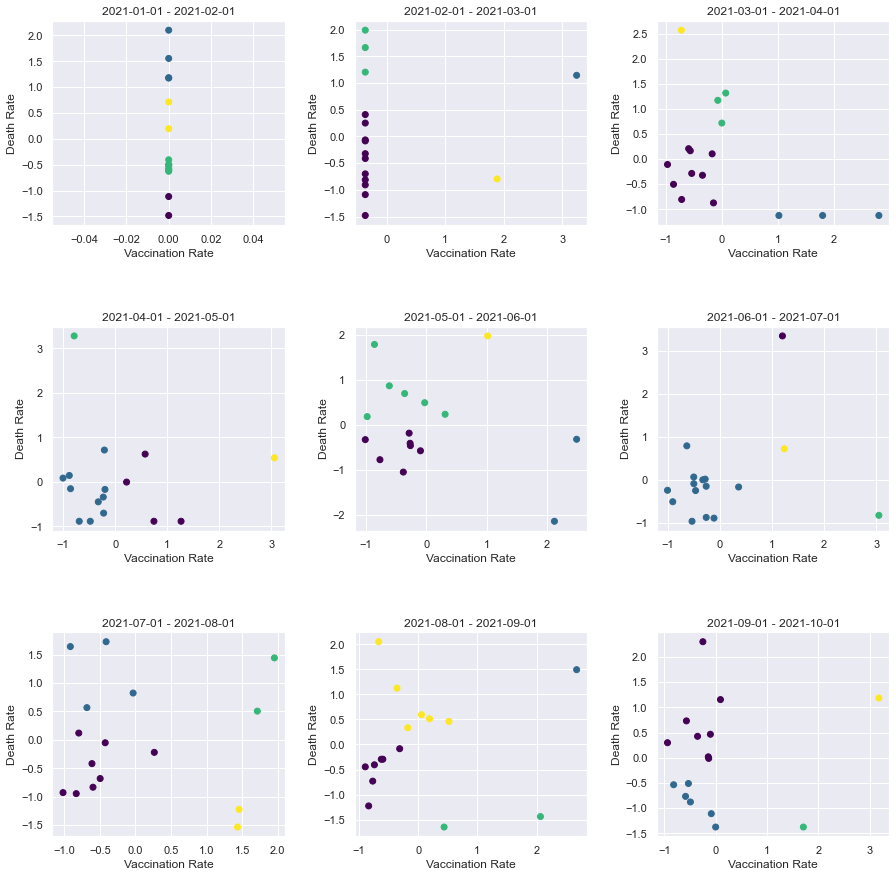

In [592]:
sns.set(rc={'figure.figsize':(18, 3)})
nrows = 3
ncols = 3
fig, axes = plt.subplots(3, 3, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 20):
    grid_combos.append((nrows, ncols, i))

dates = ['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    vax_state_date = vax_state[vax_state['date'] < date_range[1]]

    cases = []
    vaccination_rates = []
    deaths = []

    for state in states:
        cases.append(cases_state_date[cases_state_date['state'] == state]['cases_new'].sum())
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum() / cases_state_date[cases_state_date['state'] == state]['cases_new'].sum())
        # divide number of vaccinations by state population
        vaccination_rates.append(vax_state_date[vax_state_date['state'] == state]['daily_full'].sum() / population.loc[population['state'] == state, 'pop'].values[0])

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "deaths": deaths, "vaccination_rate": vaccination_rates})

    for col in cases_deaths_vaccinations:
        if cases_deaths_vaccinations[col].dtype != 'object':
            cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations

    km = KMeans(n_clusters=4, max_iter=100)
    y_clusters = km.fit_predict(cases_deaths_vaccinations)
    centroids = km.cluster_centers_

    # put back state column
    cases_deaths_vaccinations['state'] = states

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num)
    ax.scatter(cases_deaths_vaccinations['vaccination_rate'], cases_deaths_vaccinations['deaths'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Vaccination Rate')
    ax.set_ylabel('Death Rate')
    # ax.set_xticks(np.arange(-0.5, 0.5, 0.1))
    # ax.set_yticks(np.arange(-0.05, 3.5, 0.5))
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

In [571]:
cases_deaths_vaccinations

,deaths,vaccination_rate,state
0,0.022711,0.583810,Johor
1,0.026569,0.525627,Kedah
2,0.010587,0.458843,Kelantan
3,0.017574,0.639750,Melaka
4,0.031900,0.703397,Negeri Sembilan
5,0.007676,0.521127,Pahang
6,0.010898,0.536021,Perak
7,0.023220,0.650781,Perlis
8,0.017178,0.642087,Pulau Pinang
9,0.021105,0.426898,Sabah


We can see that throughout 2020, there are 0 vaccinations in all state since the vaccination campaign was yet to start. By February 2021, two states have begun their vaccination campaigns. It speeds up more rapidly by March and April, the vertical clusters start to spread out on the x-axis indicating higher vaccination numbers. In June 2021, there was a remarkable shoot where the y-axis scale completely changed. As of September 2021, the states that may require attention are those with low vaccination rates and high death rates (still very small), namely cluster 2, which contains the following states:
1. Melaka
2. Negeri Sembilan
3. Perlis
4. Selangor
5. W.P. Putrajaya

On the other hand, these are the states with relatively high vaccination rates w.r.t deaths:
1. Sarawak
2. W.P. Kuala Lumpur
3. W.P. Labuan

In [588]:
deaths_state

,date,state,deaths_new,deaths_bid,deaths_new_dod,deaths_bid_dod,deaths_pvax,deaths_fvax,deaths_tat
0,2020-03-17,Johor,1,0,1,0,0,0,0
1,2020-03-17,Kedah,0,0,0,0,0,0,0
2,2020-03-17,Kelantan,0,0,0,0,0,0,0
3,2020-03-17,Melaka,0,0,0,0,0,0,0
4,2020-03-17,Negeri Sembilan,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9147,2021-10-09,Selangor,22,13,0,0,0,0,52
9148,2021-10-09,Terengganu,1,1,0,0,0,0,3
9149,2021-10-09,W.P. Kuala Lumpur,2,0,0,0,0,0,2
9150,2021-10-09,W.P. Labuan,0,0,0,0,0,0,0


## Regression

### Can we predict the vaccination numbers? 

In [340]:
# vax_population = vax_malaysia.merge(population, on='state')
malaysia_population = population[population['state'] == 'Malaysia']['pop'].iloc[0]
vax_malaysia['cumul'] = vax_malaysia['daily_full'].cumsum()
vax_malaysia['percentage_vaccinated'] = vax_malaysia['cumul'] / malaysia_population

<AxesSubplot:xlabel='date'>

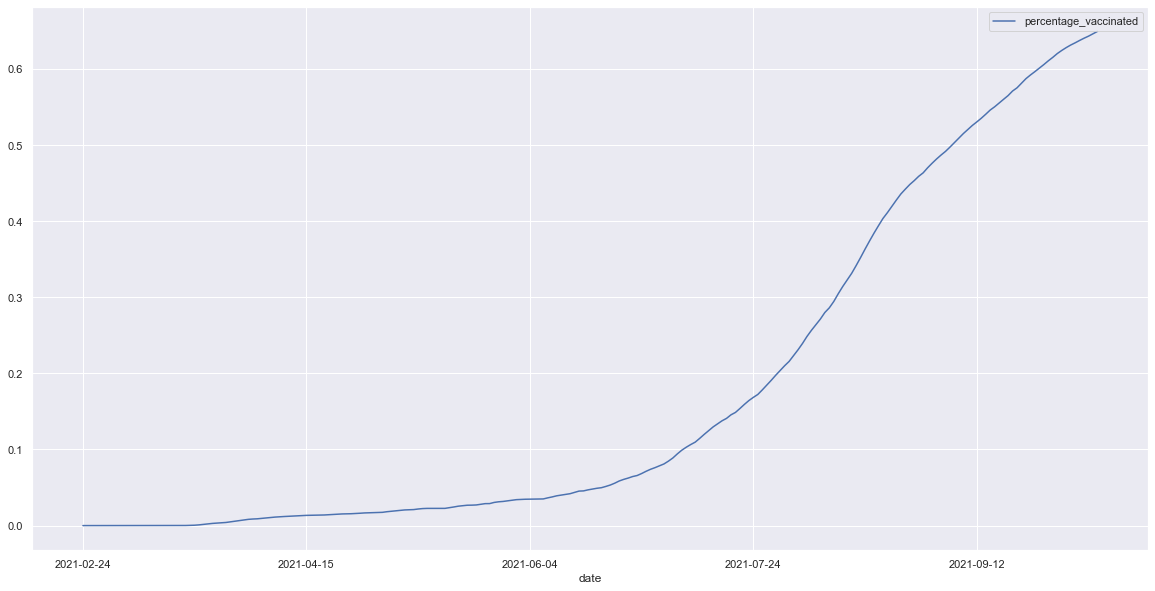

In [119]:
vax_malaysia.plot.line(x='date', y='percentage_vaccinated', figsize=(20,10))

<AxesSubplot:>

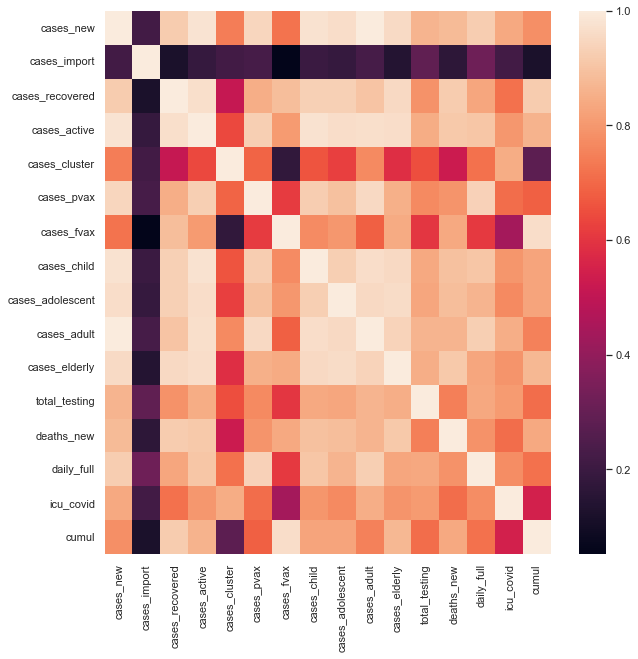

In [341]:
plt.figure(figsize=(10,10))
cases_testing_deaths_vax = cases_malaysia.merge(tests_malaysia, on='date')
cases_testing_deaths_vax = cases_testing_deaths_vax.merge(deaths_malaysia, on='date')
cases_testing_deaths_vax = cases_testing_deaths_vax.merge(vax_malaysia[['date', 'daily_full']], on='date')
icu_covid = pd.DataFrame(icu.groupby('date')['icu_covid'].sum()).reset_index()
cases_testing_deaths_vax = cases_testing_deaths_vax.merge(icu_covid, on='date')
cases_testing_deaths_vax['cumul'] = cases_testing_deaths_vax['daily_full'].cumsum()
sns.heatmap(cases_testing_deaths_vax.corr())

In [345]:
cases_testing_deaths_vax.columns

Index(['date', 'cases_new', 'cases_import', 'cases_recovered', 'cases_active',
       'cases_cluster', 'cases_pvax', 'cases_fvax', 'cases_child',
       'cases_adolescent', 'cases_adult', 'cases_elderly', 'total_testing',
       'deaths_new', 'daily_full', 'icu_covid', 'cumul'],
      dtype='object')

Select best features using Boruta

In [346]:
X = cases_testing_deaths_vax.drop(columns=['date', 'daily_full', 'cumul'])
y = cases_testing_deaths_vax['daily_full']

rf = RandomForestRegressor(n_jobs=-1, max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X.values, y.ravel())

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features

# do not run boruta again
# print('''
# Iteration: 	1 / 100
# Confirmed: 	0
# Tentative: 	14
# Rejected: 	0
# Iteration: 	2 / 100
# Confirmed: 	0
# Tentative: 	14
# Rejected: 	0
# Iteration: 	3 / 100
# Confirmed: 	0
# Tentative: 	14
# Rejected: 	0
# Iteration: 	4 / 100
# Confirmed: 	0
# Tentative: 	14
# Rejected: 	0
# Iteration: 	5 / 100
# Confirmed: 	0
# Tentative: 	14
# Rejected: 	0
# Iteration: 	6 / 100
# Confirmed: 	0
# Tentative: 	14
# Rejected: 	0
# Iteration: 	7 / 100
# show more (open the raw output data in a text editor) ...


# Iteration: 	35 / 100
# Confirmed: 	8
# Tentative: 	0
# Rejected: 	6
# array([7, 3, 1, 1, 1, 1, 1, 6, 5, 2, 4, 1, 1, 1])
# ''')

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	3
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	3
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	3
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	3
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	4
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	4
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	4
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	4
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	4
Iteration:

array([1, 4, 5, 1, 2, 1, 1, 1, 3, 1, 6, 1, 1, 1])

In [243]:
filtered.to_csv('filtered.csv')

In [349]:
# # chosen features
accept = X.columns[feat_selector.support_].to_list()
# accept = ["cases_recovered", "cases_active", "cases_cluster", "cases_pvax", "cases_fvax", "total_testing", "deaths_new", "icu_covid", "daily_cumul"]
# transform dataframe to only selected features
filtered = pd.DataFrame(feat_selector.transform(X.values), columns=accept)
# add back date and percentage vaccinated
filtered['daily_full'] = y
filtered['date'] = cases_testing_deaths_vax['date']
filtered['date'] = pd.to_datetime(filtered['date'])
filtered.set_index('date', inplace=True)
# filtered = pd.read_csv('filtered.csv', index_col=0)

In [358]:
num_features = len(filtered.columns) - 1

#### Multivariate LSTM Time-Series Analysis

In [382]:
filtered

,cases_new,cases_active,cases_pvax,cases_fvax,cases_child,cases_adult,total_testing,deaths_new,icu_covid,daily_full
date,,,,,,,,,,
2021-02-24,3545.0,30572.0,0.0,0.0,145.0,2919.0,75122.0,12.0,270.0,0
2021-02-25,1924.0,28738.0,0.0,0.0,158.0,1473.0,85929.0,13.0,274.0,0
2021-02-26,2253.0,27903.0,0.0,0.0,124.0,1822.0,80221.0,10.0,255.0,1
2021-02-27,2364.0,26937.0,0.0,0.0,147.0,1858.0,63567.0,10.0,257.0,1
2021-02-28,2437.0,26118.0,0.0,0.0,132.0,2044.0,59526.0,9.0,258.0,3
...,...,...,...,...,...,...,...,...,...,...
2021-10-02,10915.0,155499.0,1306.0,5885.0,1951.0,6756.0,102196.0,109.0,890.0,121822
2021-10-03,9066.0,150019.0,1124.0,4944.0,1700.0,5348.0,97471.0,118.0,860.0,110550
2021-10-04,8075.0,142562.0,1097.0,4287.0,1353.0,5050.0,176380.0,76.0,869.0,95379


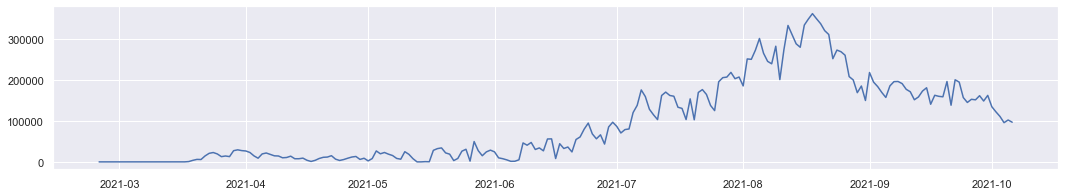

In [383]:
plt.plot(filtered['daily_full'])

In [384]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
input_data = X_scaler.fit_transform(filtered.iloc[:,:-1])
input_y = y_scaler.fit_transform(filtered.iloc[:,-1].values.reshape(-1,1))
input_data = np.concatenate((input_data, input_y), axis=1)

In [385]:
lookback = 100
total_size = input_data.shape[0]

In [386]:
X=[]
y=[]
for i in range(0, total_size - lookback):
    t = []
    for j in range(0, lookback):
        current_index = i+j
        t.append(input_data[current_index, :-1])
    X.append(t)
    y.append(input_data[lookback+i, num_features])
X, y = np.array(X), np.array(y)

In [387]:
X.shape

(125, 100, 9)

In [388]:
test_size = 50
X_test = X[-test_size:]
y_test = y[-test_size:]

X_rest = X[:-test_size]
y_rest = y[:-test_size]

X_train, X_valid, y_train, y_valid = train_test_split(X_rest, y_rest, test_size=0.15, random_state=42, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], lookback, num_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, num_features)
X_test = X_test.reshape(X_test.shape[0], lookback, num_features)

In [394]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], num_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 100, 50)           12000     
_________________________________________________________________
dropout_50 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_51 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_52 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 50)              

In [395]:
# do not run this cell, use the pretrained model, stored in "model.h5"
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    # ModelCheckpoint('./trained_models/lstm', verbose=1, save_best_only=True)
]
model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid), callbacks=callbacks)
# print('''
# Epoch 1/100
# 8/8 [==============================] - 7s 223ms/step - loss: 0.1882 - val_loss: 0.0599

# Epoch 00001: val_loss improved from inf to 0.05994, saving model to ./lstm-time-series
# Epoch 2/100
# 8/8 [==============================] - 1s 120ms/step - loss: 0.0638 - val_loss: 0.0469

# Epoch 00002: val_loss improved from 0.05994 to 0.04686, saving model to ./lstm-time-series
# Epoch 3/100
# 8/8 [==============================] - 1s 117ms/step - loss: 0.0429 - val_loss: 0.0275

# Epoch 00003: val_loss improved from 0.04686 to 0.02747, saving model to ./lstm-time-series
# Epoch 4/100
# 8/8 [==============================] - 1s 115ms/step - loss: 0.0442 - val_loss: 0.0175

# Epoch 00004: val_loss improved from 0.02747 to 0.01748, saving model to ./lstm-time-series
# Epoch 5/100
# 8/8 [==============================] - 1s 111ms/step - loss: 0.0381 - val_loss: 0.0151

# Epoch 00005: val_loss improved from 0.01748 to 0.01508, saving model to ./lstm-time-series
# Epoch 6/100
# 8/8 [==============================] - 1s 128ms/step - loss: 0.0352 - val_loss: 0.0103

# Epoch 00006: val_loss improved from 0.01508 to 0.01030, saving model to ./lstm-time-series
# Epoch 7/100
# show more (open the raw output data in a text editor) ...

# Epoch 27/100
# 8/8 [==============================] - 1s 122ms/step - loss: 0.0140 - val_loss: 0.0041

# Epoch 00027: val_loss did not improve from 0.00390
# Epoch 00027: early stopping
# <keras.callbacks.History at 0x7f7a2cf94970>
# ''')

Epoch 1/100
8/8 [==============================] - 9s 329ms/step - loss: 0.1052 - val_loss: 0.0452
Epoch 2/100
8/8 [==============================] - 1s 123ms/step - loss: 0.0309 - val_loss: 0.0304
Epoch 3/100
8/8 [==============================] - 1s 126ms/step - loss: 0.0215 - val_loss: 0.0171
Epoch 4/100
8/8 [==============================] - 1s 123ms/step - loss: 0.0161 - val_loss: 0.0228
Epoch 5/100
8/8 [==============================] - 1s 121ms/step - loss: 0.0228 - val_loss: 0.0141
Epoch 6/100
8/8 [==============================] - 1s 121ms/step - loss: 0.0149 - val_loss: 0.0209
Epoch 7/100
8/8 [==============================] - 1s 129ms/step - loss: 0.0167 - val_loss: 0.0072
Epoch 8/100
8/8 [==============================] - 1s 124ms/step - loss: 0.0093 - val_loss: 0.0048
Epoch 9/100
8/8 [==============================] - 1s 135ms/step - loss: 0.0116 - val_loss: 0.0054
Epoch 10/100
8/8 [==============================] - 1s 130ms/step - loss: 0.0107 - val_loss: 0.0154
Epoch 11/

In [396]:
predicted_vaccination = model.predict(X_test)
predicted_vaccination = y_scaler.inverse_transform(predicted_vaccination)
predicted_vaccination

array([[318866.16],
       [323708.5 ],
       [328158.75],
       [332251.22],
       [335985.88],
       [339298.25],
       [342105.2 ],
       [344428.47],
       [346345.88],
       [347967.56],
       [349356.22],
       [350566.44],
       [351575.97],
       [352358.94],
       [352918.8 ],
       [353251.7 ],
       [353396.6 ],
       [353347.03],
       [353072.84],
       [352565.2 ],
       [351815.12],
       [350851.97],
       [349723.16],
       [348463.72],
       [347132.78],
       [345731.3 ],
       [344253.94],
       [342661.28],
       [340934.4 ],
       [339119.2 ],
       [337254.12],
       [335361.06],
       [333432.16],
       [331445.4 ],
       [329414.5 ],
       [327384.5 ],
       [325372.38],
       [323340.56],
       [321236.3 ],
       [318969.97],
       [316438.3 ],
       [313569.9 ],
       [310332.56],
       [306736.44],
       [302818.5 ],
       [298607.62],
       [294083.25],
       [289181.34],
       [283897.47],
       [278246.3 ]],

In [397]:
y_scaler.inverse_transform(y_test.reshape(-1,1))

array([[360602.],
       [348107.],
       [336222.],
       [319245.],
       [309837.],
       [250965.],
       [271942.],
       [267970.],
       [259452.],
       [207496.],
       [199373.],
       [168354.],
       [184533.],
       [149353.],
       [217416.],
       [193941.],
       [183153.],
       [169012.],
       [156715.],
       [184839.],
       [195228.],
       [195615.],
       [190382.],
       [176492.],
       [170552.],
       [151130.],
       [157912.],
       [172313.],
       [180276.],
       [140190.],
       [162016.],
       [159453.],
       [158308.],
       [195473.],
       [137841.],
       [199711.],
       [194050.],
       [156492.],
       [144523.],
       [152269.],
       [150947.],
       [160988.],
       [148062.],
       [161720.],
       [134224.],
       [121822.],
       [110550.],
       [ 95379.],
       [101881.],
       [ 96466.]])

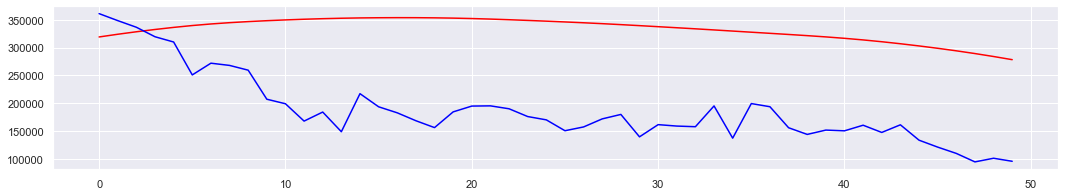

In [398]:
plt.plot(predicted_vaccination, color='red')
plt.plot(y_scaler.inverse_transform(y_test.reshape(-1,1)), color='blue')

In [399]:
mean_squared_error(y_test, model.predict(X_test))

0.18642943303539256

In [379]:
model.save('lstm-time-series.h5')

In [380]:
model2 = load_model('lstm-time-series.h5')

#### Predicting for the future
We have to bring in the latest data to predict the future. The new datasets are loaded here for that purpose.

In [373]:
vax_pop_percentage = vax_malaysia['cumul']
vax_pop_percentage = pd.DataFrame(vax_pop_percentage)
vax_pop_percentage['percentage'] = vax_pop_percentage.apply(lambda x: (vax_malaysia['cumul']/population[population['state']=='Malaysia']['pop'].item())*100,axis=0)
vax_pop_percentage['date'] = pd.to_datetime(vax_malaysia['date'])
vax_pop_percentage

,cumul,percentage,date
0,0,0.000000,2021-02-24
1,0,0.000000,2021-02-25
2,1,0.000003,2021-02-26
3,2,0.000006,2021-02-27
4,5,0.000015,2021-02-28
...,...,...,...
223,20819254,63.750495,2021-10-05
224,20915720,64.045882,2021-10-06
225,21004275,64.317046,2021-10-07
226,21104896,64.625157,2021-10-08


In [376]:
filtered['daily_full'].sum() / malaysia_population

0.6404588240337565

#### Support Vector Regression

In [400]:
# import Support Vector Regression
from sklearn.svm import SVR

X_scaler_svr = MinMaxScaler()
y_scaler_svr = MinMaxScaler()
X_svr = X_scaler_svr.fit_transform(filtered.iloc[:,:-1])
y_svr = y_scaler_svr.fit_transform(filtered.iloc[:,-1].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_svr, y_svr, test_size=0.15, random_state=42, shuffle=True)

svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr.fit(X_train, y_train)

# mean squared error
print('MSE:', mean_squared_error(y_test, svr.predict(X_test)))

MSE: 0.03598705518452522


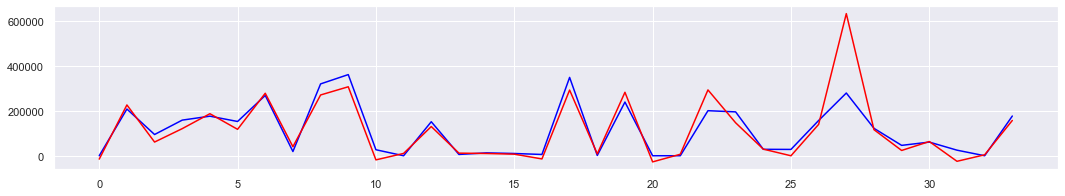

In [401]:
plt.plot(y_scaler_svr.inverse_transform(y_test.reshape(-1,1)), color='blue')
plt.plot(y_scaler_svr.inverse_transform(svr.predict(X_test).reshape(-1,1)), color='red')

#### Linear Regression

In [403]:
# import LinearRegression
from sklearn.linear_model import LinearRegression

X_scaler_svr = MinMaxScaler()
y_scaler_svr = MinMaxScaler()
X_svr = X_scaler_svr.fit_transform(filtered.iloc[:,:-1])
y_svr = y_scaler_svr.fit_transform(filtered.iloc[:,-1].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_svr, y_svr, test_size=0.15, random_state=42, shuffle=True)

lr = LinearRegression()
lr.fit(X_train, y_train)

# mean squared error
print('MSE:', mean_squared_error(y_test, lr.predict(X_test)))

MSE: 0.02318064163443515


Linear Regression and Support Vector Regression does a very good job in this case, beyond that of the multivariate LSTM.

In [ ]:
#### Old code (Failed attempt at doing multivariate LSTM)

In [196]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()

X = filtered.drop(columns=['daily_cumul'])
y = filtered['daily_cumul']
X_data = X_scaler.fit_transform(X)
Y_data = Y_scaler.fit_transform(y.values.reshape(-1,1))

In [197]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
     X_data = []
     y_data = []
     start = start + window
     if end is None:
         end = len(dataset) - horizon
     for i in range(start, end):
         indices = range(i-window, i)
         X_data.append(dataset[indices])
         indicey = range(i+1, i+1+horizon)
         y_data.append(target[indicey])
     return np.array(X_data), np.array(y_data) 

In [198]:
hist_window = 50
horizon = 50
TRAIN_SPLIT = 175
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [199]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1], 13)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
model.summary()
# Fitting the RNN to the Training set
model.fit(x_train, y_train, epochs = 30, batch_size = 32)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50, 100)           45600     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 50)            30200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 50, 1)             51        
Total params: 75,851
Trainable params: 75,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30


ValueError: in user code:

    /Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential_4: expected shape=(None, None, 13), found shape=(None, 50, 8)


In [ ]:
data_val = X_scaler.fit_transform(X_data[:50])
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = model.predict(val_rescaled)
pred
pred_inverse = Y_scaler.inverse_transform(pred.reshape(-1,1))
pred_inverse

array([[ 7909481.],
       [14706906.],
       [20602726.],
       [25506356.],
       [29704832.],
       [31878970.],
       [32326636.],
       [32397090.],
       [32302296.],
       [32459840.],
       [31866390.],
       [30732638.],
       [29305962.],
       [28042780.],
       [26936438.],
       [26151206.],
       [25022500.],
       [23496494.],
       [21832952.],
       [20147818.],
       [18451202.],
       [16823870.],
       [15436587.],
       [14924495.],
       [14839581.],
       [14673870.],
       [14652252.],
       [14439013.],
       [14116856.],
       [13692224.],
       [13005385.],
       [12251026.],
       [11828084.],
       [11334211.],
       [11046055.],
       [11814654.],
       [12640166.],
       [13475417.],
       [14764941.],
       [15658545.],
       [16347307.],
       [17039306.],
       [17209094.],
       [17244918.],
       [17217512.],
       [17182138.],
       [17351378.],
       [17305920.],
       [17963728.],
       [18655706.]],

In [ ]:
original = Y_scaler.inverse_transform(Y_data[:50].reshape(-1,1))
original

array([[6.000000e+01],
       [1.206000e+03],
       [5.322000e+03],
       [1.204600e+04],
       [1.874800e+04],
       [3.412400e+04],
       [5.579200e+04],
       [7.848500e+04],
       [9.804400e+04],
       [1.123760e+05],
       [1.281540e+05],
       [1.406920e+05],
       [1.678200e+05],
       [1.978040e+05],
       [2.265250e+05],
       [2.530000e+05],
       [2.790430e+05],
       [2.958800e+05],
       [3.059540e+05],
       [3.262390e+05],
       [3.516970e+05],
       [3.725440e+05],
       [3.906430e+05],
       [4.051660e+05],
       [4.189380e+05],
       [4.344330e+05],
       [4.586860e+05],
       [4.878260e+05],
       [5.168870e+05],
       [5.426410e+05],
       [5.593390e+05],
       [5.753720e+05],
       [5.918960e+05],
       [6.269320e+05],
       [6.677120e+05],
       [7.049720e+05],
       [7.472710e+05],
       [7.777110e+05],
       [7.949650e+05],
       [8.099010e+05],
       [8.384710e+05],
       [8.710800e+05],
       [9.019710e+05],
       [9.2

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
     def mean_absolute_percentage_error(y_true, y_pred): 
         y_true, y_pred = np.array(y_true), np.array(y_pred)
         return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
     print('Evaluation metric results:-')
     print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
     print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
     print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
     print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
     print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(original, pred_inverse)

Evaluation metric results:-
MSE is : 414943853315760.06
MAE is : 19062731.32
RMSE is : 20370170.6746841
MAPE is : 312243.7579202512
R2 is : -3759.920259646127



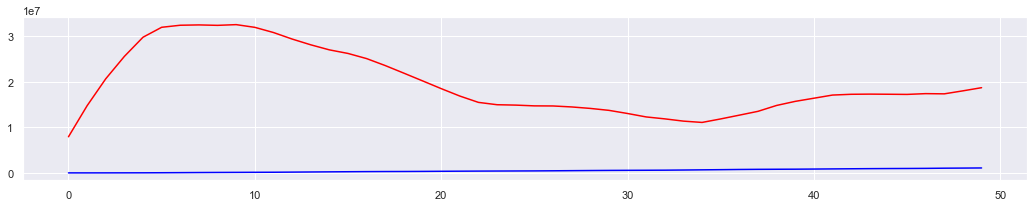

In [ ]:
plt.plot(original, color='blue', label='Original')
plt.plot(pred_inverse, color='red', label='Predicted')

### Does the current vaccination rate allow herd immunity to be achieved by 30 November 2021? You can assume that herd immunity can be achieved with 80% of the population having been vaccinated.

In [600]:
vax_malaysia['cumul_full'] = vax_malaysia['daily_full'].cumsum()

In [628]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(vax_malaysia['cumul_full'], start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=False,
                            d=1, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5166.004, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5859.863, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5179.570, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5715.171, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6007.510, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5167.775, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5167.537, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5675.693, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5167.355, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5169.513, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5165.227, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5858.010, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5179.805, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5165.739, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  228
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2579.614
Date:                Thu, 28 Oct 2021   AIC                           5165.227
Time:                        16:44:15   BIC                           5175.502
Sample:                             0   HQIC                          5169.374
                                - 228                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9947      0.005    188.399      0.000       0.984       1.005
ma.L1         -0.2972      0.049     -6.098      0.000      -0.393      -0.202
sigma2      4.449e+08   1.94e-11    2.3e+19      0.000    4.45e+08    4.45e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                45.70
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):              31.19   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.31e+35. Standard errors may be unstable.
"""

In [629]:
train = vax_malaysia[:len(vax_malaysia) - 50]
test = vax_malaysia[len(vax_malaysia) - 50:]

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['cumul_full'], order=(1, 1, 1))
result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.34213D+01    |proj g|=  7.68117D+01

At iterate    5    f=  1.16830D+01    |proj g|=  4.35110D-01

At iterate   10    f=  1.12971D+01    |proj g|=  2.32647D-02

At iterate   15    f=  1.12616D+01    |proj g|=  2.03396D-02


 This problem is unconstrained.



At iterate   20    f=  1.12553D+01    |proj g|=  1.68434D-03

At iterate   25    f=  1.12544D+01    |proj g|=  3.78269D-04

At iterate   30    f=  1.12542D+01    |proj g|=  4.56897D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     37      1     0     0   6.695D-06   1.125D+01
  F =   11.254182702974498     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             cumul_full   No. Observations:                  178
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2003.245
Date:                Thu, 28 Oct 2021   AIC                           4012.489
Time:                        16:44:24   BIC                           4022.017
Sample:                             0   HQIC                          4016.353
                                - 178                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.006    173.427      0.000       0.989       1.011
ma.L1         -0.3343      0.052     -6.378      0.000      -0.437      -0.232
sigma2       4.03e+08   3.02e-11   1.34e+19      0.000    4.03e+08    4.03e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                48.19
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):              53.61   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.1e+35. Standard errors may be unstable.
"""

<AxesSubplot:>

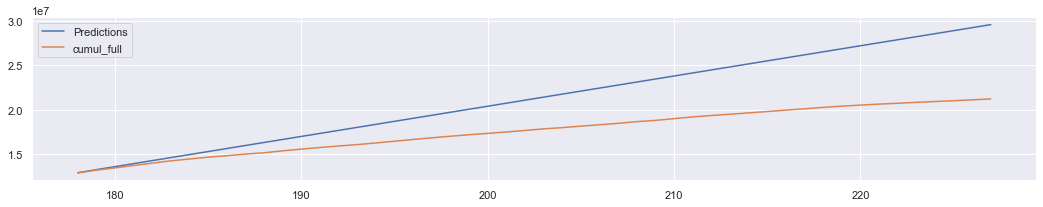

In [631]:
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start, end, typ='levels').rename('Predictions')

predictions.plot(legend=True)
test['cumul_full'].plot(legend=True)

<AxesSubplot:>

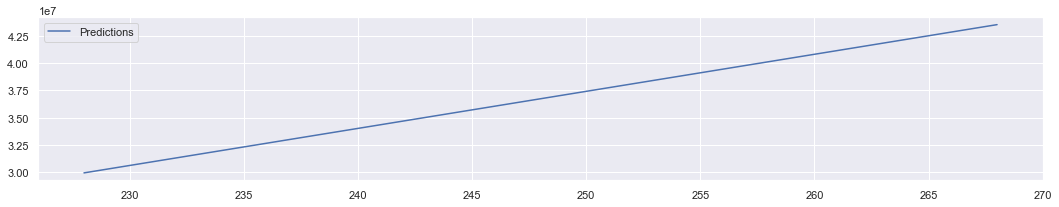

In [635]:
start = 228
end = 268
predictions = result.predict(start, end, typ='levels').rename('Predictions')
predictions.plot(legend=True)

In [647]:
cumul_vaccine = list(vax_malaysia['cumul_full'])
cumul_vaccine += predictions.tolist()
print(len(cumul_vaccine))

269


In [652]:
from datetime import date, timedelta
date1 = date(2021, 10, 10)
str(date1 + timedelta(days=30))

'2021-11-09'

In [664]:
vax_malaysia['date'] 
def add_date(dt, row):
    split = dt.split('-')
    year = int(split[0])
    month = int(split[1])
    day = int(split[2])
    date_orig = date(year, month, day)
    new_date = date_orig + timedelta(days=row)
    return str(new_date)
dts = [add_date('2021-11-09', i) for i in range(1, 42)]
dts = list(vax_malaysia['date']) + dts

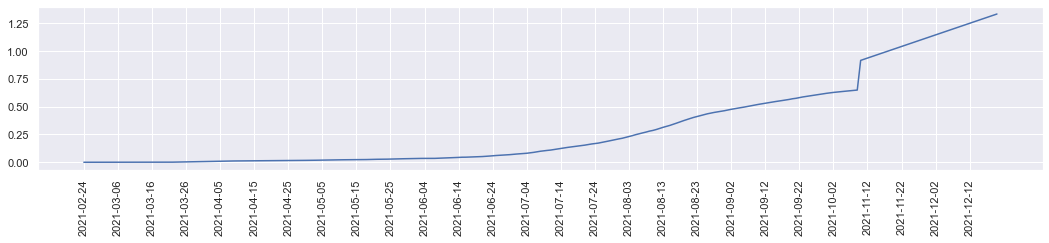

In [671]:
sns.lineplot(dts, (cumul_vaccine / malaysia_population))
plt.xticks([date for i, date in enumerate(dts) if i % 10 == 0], rotation=90)
plt.show()

Based on ARIMA auto-regressive prediction, it is possible that herd immunity will be reached before 30 November, if it continues at this rate.

### Can we predict mortality numbers across the nation? (don't need time series) - Eugene

In [ ]:
dataset1 = before_pp_cases_malaysia.copy()
dataset2 = before_pp_deaths_malaysia.copy()
dataset2 = dataset2[['date','deaths_new']]
dataset3 = before_pp_tests_malaysia.copy()
dataset4 = before_pp_vax_malaysia.copy()
total_dataset = dataset1.merge(dataset2, how='inner', on=['date'] )
total_dataset.fillna(0, inplace=True)
total_dataset = total_dataset.merge(dataset3, how='inner', on=['date'] )
total_dataset.fillna(0, inplace=True)
total_dataset = total_dataset.merge(dataset4, how='inner', on=['date'] )
total_dataset.fillna(0, inplace=True)
total_dataset

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,...,cumul_partial_child,cumul_full_child,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,3545,1,3331,30572,2483.0,0.0,0.0,145.0,84.0,...,0,0,60,0,0,0,0,0,0,0
1,2021-02-25,1924,6,3752,28738,705.0,0.0,0.0,158.0,72.0,...,0,0,1146,0,0,0,0,0,0,0
2,2021-02-26,2253,7,3085,27903,1136.0,0.0,0.0,124.0,75.0,...,0,0,4115,1,0,0,0,0,0,0
3,2021-02-27,2364,1,3320,26937,1100.0,0.0,0.0,147.0,100.0,...,0,0,6723,1,0,0,0,0,0,0
4,2021-02-28,2437,1,3251,26118,1404.0,0.0,0.0,132.0,83.0,...,0,0,6699,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2021-10-02,10915,7,15396,155499,656.0,1306.0,5885.0,1951.0,938.0,...,1666131,92949,85634,73484,1907,13712,116,32558,1644,2462
221,2021-10-03,9066,12,14454,150019,388.0,1124.0,4944.0,1700.0,764.0,...,1751834,108826,87792,66883,1907,9508,18,33146,682,6638
222,2021-10-04,8075,6,15456,142562,731.0,1097.0,4287.0,1353.0,641.0,...,1862399,114124,123351,58454,2620,8339,144,26749,1348,807
223,2021-10-05,8817,14,15615,135685,619.0,1062.0,5106.0,1386.0,686.0,...,1967549,120402,119323,59655,2440,13395,130,26496,1828,767


In [ ]:
X = total_dataset.drop(['date','deaths_new'], axis=1)  
y = total_dataset['deaths_new']  

selector = SelectKBest(mutual_info_regression, k=6)
selector.fit(X, y)
mutual_info_best = X.columns[selector.get_support()]

rfe_selector = RFE(LinearRegression(), n_features_to_select=10)
rfe_selector.fit(X, y)
rfe_best = X.columns[rfe_selector.get_support()]

rf = RandomForestRegressor(n_jobs=4, oob_score=True)
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0)
boruta.fit(X.values, y.ravel())
boruta_best = [X.columns[i] for i, x in enumerate(boruta.support_) if x]

print(boruta_best)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	16 / 100
Confirmed: 	10
Tentative: 	7
Rejected: 	21


In [ ]:
train_model_dataset = total_dataset[boruta_best]
train_model_dataset['deaths_new'] = total_dataset['deaths_new']

In [ ]:
X = train_model_dataset.drop(['deaths_new'], axis=1)  
X = MinMaxScaler().fit_transform(X)
y = train_model_dataset['deaths_new']  
y = MinMaxScaler().fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2) 

In [ ]:
regressor = DecisionTreeRegressor(max_depth=2, criterion="mae", splitter="best")  
regressor.fit(X_train, y_train) 
pred = regressor.predict(X_test)

In [ ]:
mae = round(mean_absolute_error(y_test, pred),4)
mse = round(mean_squared_error(y_test, pred),4)

print('DecisionTreeRegressor MAE: ', mae)
print('DecisionTreeRegressor MSE: ', mse)

DecisionTreeRegressor MAE:  0.057
DecisionTreeRegressor MSE:  0.0123


First of all, we perform feature selection from cases_malaysia.csv, deaths_malaysia.csv, and tests_malaysia.csv datasets by using Boruta in python. After that , the  features that are being selected will be used to train our decision tree regressor model. For our model, it is able to archieve a 0.057 mean absolute error and a 0.0123 mean squared error.

### Can we predict mortality numbers for Melaka, Negeri Sembilan, Perlis, Selangor and W.P. Putrajaya? (don't need time series) - Zhi Hang

In [ ]:
def state_mortality_prediction(state) :
    dataset1 = before_pp_cases_state.copy()
    dataset2 = before_pp_deaths_state.copy()
    dataset2 = dataset2[['date','state','deaths_new']]
    dataset3 = before_pp_tests_state.copy()
    dataset4 = before_pp_vax_state.copy()
    total_dataset = dataset1[dataset1['state'] == state].merge(dataset2[dataset2['state'] == state], how='inner', on=['date','state'] )
    total_dataset.fillna(0, inplace=True)
    total_dataset = total_dataset.merge(dataset3[dataset3['state'] == state], how='inner', on=['date','state'] )
    total_dataset.fillna(0, inplace=True)
    total_dataset = total_dataset.merge(dataset4[dataset4['state'] == state], how='inner', on=['date','state'] )
    total_dataset.fillna(0, inplace=True)
    X = total_dataset.drop(['date','deaths_new','state'], axis=1)  
    y = total_dataset['deaths_new']  

    selector = SelectKBest(mutual_info_regression, k=6)
    selector.fit(X, y)
    mutual_info_best = X.columns[selector.get_support()]

    rfe_selector = RFE(LinearRegression(), n_features_to_select=10)
    rfe_selector.fit(X, y)
    rfe_best = X.columns[rfe_selector.get_support()]

    rf = RandomForestRegressor(n_jobs=4, oob_score=True)
    boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0)
    boruta.fit(X.values, y.ravel())
    boruta_best = [X.columns[i] for i, x in enumerate(boruta.support_) if x]
    print(boruta_best)

    return boruta_best,total_dataset

In [ ]:
def get_result(boruta_best , total_dataset) :
    train_model_dataset = total_dataset[boruta_best]
    train_model_dataset['deaths_new'] = total_dataset['deaths_new']
    X = train_model_dataset.drop(['deaths_new'], axis=1)  
    X = MinMaxScaler().fit_transform(X)
    y = train_model_dataset['deaths_new']  
    y = MinMaxScaler().fit_transform(y.values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2) 
    regressor = DecisionTreeRegressor(max_depth=2, criterion="mae", splitter="best")  
    regressor.fit(X_train, y_train) 
    pred = regressor.predict(X_test)
    mae = round(mean_absolute_error(y_test, pred),4)
    mse = round(mean_squared_error(y_test, pred),4)

    print('DecisionTreeRegressor MAE: ', mae)
    print('DecisionTreeRegressor MSE: ', mse)

In [ ]:
boruta_best_Melaka , total_dataset_Melaka = state_mortality_prediction('Melaka')
boruta_best_Negeri_Sembilan , total_dataset_Negeri_Sembilan = state_mortality_prediction('Negeri Sembilan')
boruta_best_Perlis , total_dataset_Perlis = state_mortality_prediction('Perlis')
boruta_best_Selangor , total_dataset_Selangor = state_mortality_prediction('Selangor')
boruta_best_WP_Putrajaya , total_dataset_WP_Putrajaya = state_mortality_prediction('W.P. Putrajaya')

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	27
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	27
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	27
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	27
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	27
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	27
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	27
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	27
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	27
I

In [ ]:
print("Melaka")
get_result(boruta_best_Melaka , total_dataset_Melaka)
print("")
print("Negeri Sembilan")
get_result(boruta_best_Negeri_Sembilan , total_dataset_Negeri_Sembilan)
print("")
print("Perlis")
get_result(boruta_best_Perlis , total_dataset_Perlis)
print("")
print("Selangor")
get_result(boruta_best_Selangor , total_dataset_Selangor)
print("")
print("W.P. Putrajaya")
get_result(boruta_best_WP_Putrajaya , total_dataset_WP_Putrajaya)
print("")

Melaka
DecisionTreeRegressor MAE:  0.1111
DecisionTreeRegressor MSE:  0.0205

Negeri Sembilan
DecisionTreeRegressor MAE:  0.1655
DecisionTreeRegressor MSE:  0.0845

Perlis
DecisionTreeRegressor MAE:  0.1333
DecisionTreeRegressor MSE:  0.0583

Selangor
DecisionTreeRegressor MAE:  0.0554
DecisionTreeRegressor MSE:  0.0042

W.P. Putrajaya
DecisionTreeRegressor MAE:  0.1
DecisionTreeRegressor MSE:  0.0833



For these questions, we used boruta for the features selection part and the datasets involved are cases_state.csv, deaths_state.csv, tests_state.csv, and vax_state.csv. After the features are selected, we will use the features in our decision tree regressor model to perform the prediction. Based on our results, Selangor scored the lowest value in the mean absolute error which is only 0.0554 and Selangor also scored the lowest value in the mean squared error result,0.0042.

## Classification

### Can we classify individual location check-ins in Malaysia using other variables (Low, Medium or High)?

<AxesSubplot:>

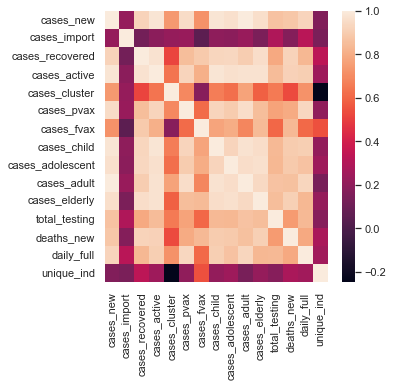

In [ ]:
cases_testing_deaths_vax_checkins = cases_malaysia.merge(tests_malaysia, on='date')
cases_testing_deaths_vax_checkins = cases_testing_deaths_vax_checkins.merge(deaths_malaysia, on='date')
cases_testing_deaths_vax_checkins = cases_testing_deaths_vax_checkins.merge(vax_malaysia[['date', 'daily_full']], on='date')
cases_testing_deaths_vax_checkins = cases_testing_deaths_vax_checkins.merge(checkins[['date', 'unique_ind']], on='date')
plt.figure(figsize=(5,5))
sns.heatmap(cases_testing_deaths_vax_checkins.corr())

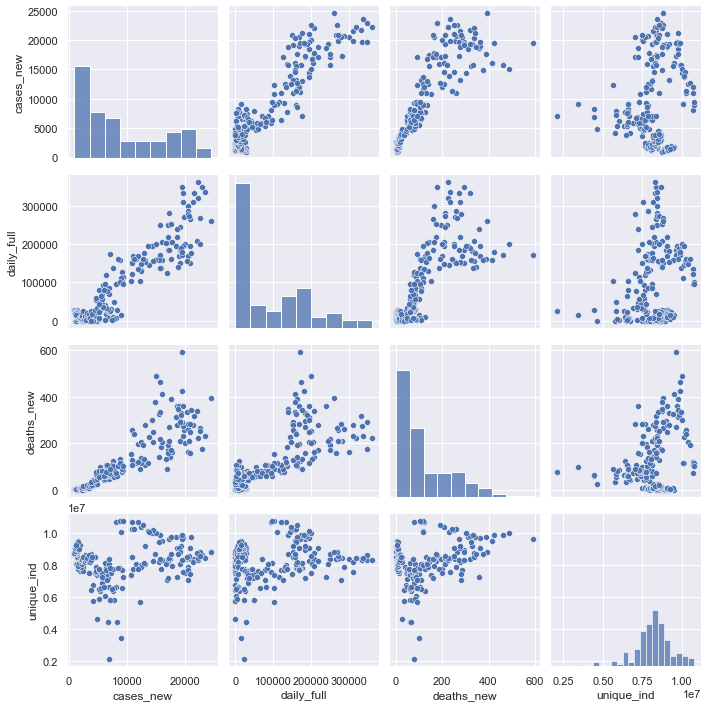

In [ ]:
sns.pairplot(cases_testing_deaths_vax_checkins, vars=['cases_new','daily_full','deaths_new','unique_ind'])

In [ ]:
cases_testing_deaths_vax_checkins['unique_ind'].max()
cases_testing_deaths_vax_checkins['ind_checkins_class'] = pd.cut(cases_testing_deaths_vax_checkins['unique_ind'], 3, labels=['Low', 'Medium', 'High'])
cases_testing_deaths_vax_checkins.drop(['unique_ind'], axis=1, inplace=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = cases_testing_deaths_vax_checkins.drop(columns=['date', 'ind_checkins_class'])
y = cases_testing_deaths_vax_checkins['ind_checkins_class']

rf = RandomForestClassifier(n_jobs=-1, max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X.values, y.ravel())

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
I

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
# chosen features
accept = X.columns[feat_selector.support_].to_list()
# transform dataframe to only selected features
filtered = pd.DataFrame(feat_selector.transform(X.values), columns=accept)
# add back date and percentage vaccinated
filtered['ind_checkins_class'] = y
filtered['date'] = cases_testing_deaths_vax_checkins['date']
filtered['date'] = pd.to_datetime(filtered['date'])
filtered.set_index('date', inplace=True)
filtered

,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,total_testing,deaths_new,daily_full,ind_checkins_class
date,,,,,,,,,,,,,,,
2021-02-24,3545.0,1.0,3331.0,30572.0,2483.0,0.0,0.0,145.0,84.0,2919.0,173.0,75122.0,12.0,0.0,Medium
2021-02-25,1924.0,6.0,3752.0,28738.0,705.0,0.0,0.0,158.0,72.0,1473.0,155.0,85929.0,13.0,0.0,Medium
2021-02-26,2253.0,7.0,3085.0,27903.0,1136.0,0.0,0.0,124.0,75.0,1822.0,173.0,80221.0,10.0,1.0,Medium
2021-02-27,2364.0,1.0,3320.0,26937.0,1100.0,0.0,0.0,147.0,100.0,1858.0,162.0,63567.0,10.0,1.0,Medium
2021-02-28,2437.0,1.0,3251.0,26118.0,1404.0,0.0,0.0,132.0,83.0,2044.0,113.0,59526.0,9.0,3.0,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-02,10915.0,7.0,15396.0,155499.0,656.0,1306.0,5885.0,1951.0,938.0,6756.0,1166.0,102196.0,109.0,121822.0,High
2021-10-03,9066.0,12.0,14454.0,150019.0,388.0,1124.0,4944.0,1700.0,764.0,5348.0,1087.0,97471.0,118.0,110550.0,High
2021-10-04,8075.0,6.0,15456.0,142562.0,731.0,1097.0,4287.0,1353.0,641.0,5050.0,948.0,176380.0,76.0,95379.0,High


In [ ]:
from imblearn.over_sampling import SMOTE
# import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
# SMOTE dataset
X = filtered.drop(columns=['ind_checkins_class'])
y = filtered['ind_checkins_class']
smt = SMOTE(random_state=42, k_neighbors=3)
X_smt, y_smt = smt.fit_resample(X, y)

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_smt, y_smt, test_size=0.2, random_state=42)

#### Random Forest Classifier

In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf.fit(X_train, y_train)
# get score
accuracy = rf.score(X_test, y_test)
# F1-Score
f1 = f1_score(y_test, rf.predict(X_test), average='weighted')

print('Accuracy of Random Forest: ', accuracy)
print('F1-Score of Random Forest: ', f1)

Accuracy of Random Forest:  0.9080459770114943
F1-Score of Random Forest:  0.9087480725737069


#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()
log.fit(X_train, y_train)
accuracy = log.score(X_test, y_test)
f1 = f1_score(y_test, log.predict(X_test), average='weighted')

print('Accuracy of Logistic Regression: ', accuracy)
print('F1-Score of Logistic Regression: ', f1)

Accuracy of Logistic Regression:  0.7471264367816092
F1-Score of Logistic Regression:  0.7427954953193445


#### Naive Bayes Classifier

In [ ]:
# import naive bayes classifier
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

accuracy = gnb.score(X_test, y_test)
f1 = f1_score(y_test, gnb.predict(X_test), average='weighted')

print('Accuracy of Naive Bayes: ', accuracy)
print('F1-Score of Naive Bayes: ', f1)

Accuracy of Naive Bayes:  0.6091954022988506
F1-Score of Naive Bayes:  0.5943829569445332


### Can we classify whether a day is a public holiday based on the data given? (hold first)

In [411]:
import holidays

In [432]:
checkins

,date,checkins,unique_ind,unique_loc
0,2020-12-01,17492265,6614474,630363
1,2020-12-02,17695726,6667261,648752
2,2020-12-03,17063123,6549583,645604
3,2020-12-04,18350879,6803979,622383
4,2020-12-05,19711082,6845366,573132
...,...,...,...,...
307,2021-10-04,28597344,10713530,875488
308,2021-10-05,28991261,10785507,887285
309,2021-10-06,28902108,10762592,889917
310,2021-10-07,29221297,10867785,892105


In [445]:
checkins_publicholidays = checkins.copy()
checkins_publicholidays['holiday'] = checkins_publicholidays['date'].apply(lambda x: str(x) in holidays.CountryHoliday('MY'))

In [446]:
checkins_publicholidays['holiday'].value_counts()

False    299
True      13
Name: holiday, dtype: int64

In [448]:
checkins_publicholidays.corr()

,checkins,unique_ind,unique_loc,holiday
checkins,1.000000,0.919262,0.697744,-0.173647
unique_ind,0.919262,1.000000,0.763946,-0.201761
unique_loc,0.697744,0.763946,1.000000,-0.332999
holiday,-0.173647,-0.201761,-0.332999,1.000000


In [438]:
'2020-12-25' in holidays.Malaysia()

True

In [423]:
malaysia_holidays

{}

### Can we predict the type of vaccine based on the symptoms?

In [452]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder

In [454]:
vaccine_prediction = aefi.copy()
vaccine_prediction['vaxtype_label'] = LabelEncoder().fit_transform(vaccine_prediction['vaxtype'])
vaccine_prediction['vaxtype_label'].value_counts()

2    217
3    184
0    148
1     33
Name: vaxtype_label, dtype: int64

In [456]:
vaccine_prediction.drop(columns=['daily_total'], inplace=True)

In [472]:
# recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X = vaccine_prediction.drop(columns=['date', 'vaxtype', 'vaxtype_label'])
y = vaccine_prediction['vaxtype_label']

logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X, y)

X_transformed = pd.DataFrame(rfe.transform(X), columns=X.columns[rfe.support_])
X_transformed

,daily_nonserious_mysj,daily_nonserious_npra,daily_serious_npra,daily_nonserious_mysj_dose1,d1_site_pain,d1_site_redness,d1_tiredness,d1_headache,d1_muscle_pain,d1_joint_pain,d1_weakness,d1_fever,d1_vomiting,d1_chills,d1_rash,d2_site_pain,d2_headache,d2_joint_pain,d2_weakness,d2_chills
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,29,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,165,6,0,149,64,8,81,69,37,28,57,34,20,25,14,10,4,3,4,1
578,1320,0,1,1294,927,67,788,855,610,527,680,858,218,662,43,16,11,7,10,7
579,2151,81,8,2007,1553,103,932,769,525,279,521,288,171,217,74,90,72,29,42,21
580,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [473]:
# X_scaler = StandardScaler()
# X_scaled = X_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [478]:
from imblearn.over_sampling import SMOTE
# import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
# SMOTE dataset

smt = SMOTE(random_state=42, k_neighbors=3)
X_smt, y_smt = smt.fit_resample(X_train, y_train)

### Logistic Regression

In [480]:
# import f1_score
from sklearn.metrics import f1_score

logreg = LogisticRegression()
logreg.fit(X_smt, y_smt)

# Accuracy
accuracy = logreg.score(X_test, y_test)
# F1 score
f1 = f1_score(y_test, logreg.predict(X_test), average='weighted')

print('Accuracy of Logistic Regression: ', accuracy)
print('F1-Score of Logistic Regression: ', f1)

Accuracy of Logistic Regression:  0.9230769230769231
F1-Score of Logistic Regression:  0.925324609380588


### Support Vector Classification with GridSearchCV hyperparameter tuning

In [482]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_smt, y_smt)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.490 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.490 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.493 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.493 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.507 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.497 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.490 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.493 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.493 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.497 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [483]:
grid.best_estimator_

SVC(C=1000, gamma=0.0001)

In [486]:
# import f1_score
from sklearn.metrics import f1_score
# import supportvectorclassifier

# get best model
svc = grid.best_estimator_

# Accuracy
accuracy = svc.score(X_test, y_test)
# F1 score
f1 = f1_score(y_test, svc.predict(X_test), average='weighted')

print('Accuracy of Support Vector Classification: ', accuracy)
print('F1-Score of Support Vector Classification: ', f1)

Accuracy of Support Vector Classification:  0.7606837606837606
F1-Score of Support Vector Classification:  0.7589776366169341
